# Assignment 1 - Employee Attrition Prediction

### 1. Context

TechNova Solutions, a mid-sized IT services company with ~1,200 employees, has been facing an attrition rate well above industry standards. Despite offering competitive salaries and benefits, the company struggles to retain talent, particularly in technical and client-facing roles. This turnover has increased costs, delayed projects, and reduced overall employee satisfaction.

### 2. Problem Statement
You have recently been hired as a Data Scientist at TechNova Solutions to help the HR department tackle a rising attrition problem. The company currently lacks a systematic way to identify employees who are at risk of leaving, which means retention efforts are applied too late — only after employees have already decided to resign.
This reactive approach has led to:
- Increased recruitment and onboarding costs.
- Disruption of client projects due to sudden departures.
- Declining morale among teams with frequent turnover.

Your role is to bring a data-driven solution that not only predicts which employees are most at risk of leaving but also helps HR make smarter decisions on incentives and retention strategies. For example, employees identified as high performers with a high risk of churn can be prioritized for bonuses, career growth plans, or other incentives. Conversely, the company can optimize resources by not over-investing in employees who are already disengaged and unlikely to stay even with incentives.


### 3. Objective
- Analyze the dataset to uncover the key factors influencing attrition.
- Build a predictive model that can classify whether an employee is likely to leave.
- Provide actionable recommendations that can help HR improve retention and employee satisfaction.

In [69]:
#Import necessary libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

import pandas as pd
import pathlib
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report, make_scorer
)
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [3]:
# Load dataset
DATA_DIR = pathlib.Path("data")
RAW_FILE = DATA_DIR / "employee_churn_dataset.csv"

df = pd.read_csv(RAW_FILE)

### 4. Data Understanding

**Observations:**
- The dataset contains 10,000 records and 22 features.
- The majority of fields match their expected types based on the data dictionary specification.
- "Salary" and "Distance from Home" needs to be converted from integer to float.
- Work-Life Balance feature is stored as text labels (“Poor”, "Average", “Good”, “Excellent”) instead of numeric values (1–4).
- The dataset encodes Manager Feedback Score on a 1–10 scale, while the data dictionary specifies 1–5. We will proceed by retaining 1–10 and document this deviation.

In [4]:
# show shape of the dataset and first 5 rows
print("Shape:", df.shape)
df.head()

Shape: (10000, 22)


,Employee ID,Age,Gender,Education Level,Marital Status,Tenure,Job Role,Department,Salary,Work Location,...,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Work-Life Balance,Average Monthly Hours Worked,Absenteeism,Distance from Home,Manager Feedback Score,Churn
0,E00001,50,Male,Bachelor's,Married,5,Analyst,Marketing,93422,Remote,...,35,0,16,0.03,Poor,155,14,15,7.9,0
1,E00002,36,Male,Bachelor's,Married,4,Manager,Sales,44589,On-site,...,1,0,12,0.39,Average,162,2,8,5.2,0
2,E00003,29,Male,Bachelor's,Married,3,Sales,IT,56768,Hybrid,...,41,0,2,0.62,Poor,243,6,21,6.3,0
3,E00004,42,Male,Bachelor's,Single,12,Analyst,Sales,79009,On-site,...,33,0,8,0.73,Good,291,11,25,7.4,0
4,E00005,40,Other,Bachelor's,Married,1,Sales,HR,81982,On-site,...,30,0,13,0.52,Average,272,3,1,4.1,0


In [5]:
# check data types and structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Employee ID                   10000 non-null  object 
 1   Age                           10000 non-null  int64  
 2   Gender                        10000 non-null  object 
 3   Education Level               10000 non-null  object 
 4   Marital Status                10000 non-null  object 
 5   Tenure                        10000 non-null  int64  
 6   Job Role                      10000 non-null  object 
 7   Department                    10000 non-null  object 
 8   Salary                        10000 non-null  int64  
 9   Work Location                 10000 non-null  object 
 10  Performance Rating            10000 non-null  int64  
 11  Projects Completed            10000 non-null  int64  
 12  Training Hours                10000 non-null  int64  
 13  Pr

In [6]:
#c check the unique values in Manager Feedback Score since there is discrepancy with data dictionary
df["Manager Feedback Score"].unique()

array([ 7.9,  5.2,  6.3,  7.4,  4.1,  2.1,  4.9,  7.3,  4.7,  6.8,  1.1,
        7. ,  1.5, 10. ,  6. ,  8.9,  8.1,  1.6,  5.3,  7.7,  7.2,  6.9,
        8.4,  2.7,  3.2,  2.5,  4. ,  6.5,  3.1,  5. ,  3.7,  9.1,  3.4,
        9.8,  4.2,  2. ,  6.6,  1.9,  3.5,  3.6,  4.5,  9.9,  6.2,  6.4,
        8. ,  9.7,  4.4,  8.5,  2.2,  6.7,  7.1,  4.3,  2.9,  2.6,  2.3,
        6.1,  9.6,  9. ,  8.2,  4.6,  7.8,  5.4,  5.7,  9.5,  5.6,  1.3,
        3.8,  2.8,  5.5,  8.7,  4.8,  9.2,  9.4,  3. ,  8.8,  1.8,  1. ,
        2.4,  1.4,  1.2,  1.7,  5.9,  3.3,  8.6,  7.5,  5.8,  9.3,  5.1,
        8.3,  7.6,  3.9])

### Action: Convert to correct data types
- "Salary" and "Distance from Home" were converted from integer to float.
- Since the categories follow an ordinal scale, will encode using OrdinalEncoder to fix data type and preserve ranking information for model compatibility.
- A new column, Work-Life Balance Encoded, was created to store the numeric representation (1–4), allowing analysis while retaining the original text labels for reference and interpretability.

In [7]:
# Convert data types as needed
df["Salary"] = df["Salary"].astype(float)
df["Distance from Home"] = df["Distance from Home"].astype(float)

# confirm changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Employee ID                   10000 non-null  object 
 1   Age                           10000 non-null  int64  
 2   Gender                        10000 non-null  object 
 3   Education Level               10000 non-null  object 
 4   Marital Status                10000 non-null  object 
 5   Tenure                        10000 non-null  int64  
 6   Job Role                      10000 non-null  object 
 7   Department                    10000 non-null  object 
 8   Salary                        10000 non-null  float64
 9   Work Location                 10000 non-null  object 
 10  Performance Rating            10000 non-null  int64  
 11  Projects Completed            10000 non-null  int64  
 12  Training Hours                10000 non-null  int64  
 13  Pr

In [8]:
# check the unique values in Work-Life Balance since there is error during data type convertion to int
df["Work-Life Balance"].unique()

array(['Poor', 'Average', 'Good', 'Excellent'], dtype=object)

In [9]:
# Convert Work-Life Balance to numeric using Ordinal Encoding
wlb_norm = df['Work-Life Balance'].astype(str).str.strip().str.lower()

ordered_labels = [["poor", "average", "good", "excellent"]]

oe = OrdinalEncoder(
    categories=ordered_labels,
    handle_unknown='use_encoded_value',
    unknown_value=np.nan
)

df['Work-Life Balance Encoded'] = (oe.fit_transform(wlb_norm.to_frame()).astype(int) + 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Employee ID                   10000 non-null  object 
 1   Age                           10000 non-null  int64  
 2   Gender                        10000 non-null  object 
 3   Education Level               10000 non-null  object 
 4   Marital Status                10000 non-null  object 
 5   Tenure                        10000 non-null  int64  
 6   Job Role                      10000 non-null  object 
 7   Department                    10000 non-null  object 
 8   Salary                        10000 non-null  float64
 9   Work Location                 10000 non-null  object 
 10  Performance Rating            10000 non-null  int64  
 11  Projects Completed            10000 non-null  int64  
 12  Training Hours                10000 non-null  int64  
 13  Pr

In [10]:
# Check unique combinations of original vs encoded values
df[['Work-Life Balance', 'Work-Life Balance Encoded']].drop_duplicates().sort_values('Work-Life Balance Encoded')


,Work-Life Balance,Work-Life Balance Encoded
0,Poor,1
1,Average,2
3,Good,3
8,Excellent,4


**Observations:**
- The dataset includes demographic, performance and job related attributes such as Age, Gender, Tenure, Department, Salary, Satisfaction Level, and others.
- There are no missing values and duplicated rows detected.
- We can conclude that the dataset is clean and ready for analysis

In [11]:
# view column names
list(df.columns)

['Employee ID',
 'Age',
 'Gender',
 'Education Level',
 'Marital Status',
 'Tenure',
 'Job Role',
 'Department',
 'Salary',
 'Work Location',
 'Performance Rating',
 'Projects Completed',
 'Training Hours',
 'Promotions',
 'Overtime Hours',
 'Satisfaction Level',
 'Work-Life Balance',
 'Average Monthly Hours Worked',
 'Absenteeism',
 'Distance from Home',
 'Manager Feedback Score',
 'Churn',
 'Work-Life Balance Encoded']

In [12]:
# check for missing values
df.isna().sum()

Employee ID                     0
Age                             0
Gender                          0
Education Level                 0
Marital Status                  0
Tenure                          0
Job Role                        0
Department                      0
Salary                          0
Work Location                   0
Performance Rating              0
Projects Completed              0
Training Hours                  0
Promotions                      0
Overtime Hours                  0
Satisfaction Level              0
Work-Life Balance               0
Average Monthly Hours Worked    0
Absenteeism                     0
Distance from Home              0
Manager Feedback Score          0
Churn                           0
Work-Life Balance Encoded       0
dtype: int64

In [13]:
# check for duplicate rows
df.duplicated().sum()

np.int64(0)

**Observations:**
- The target variable is "Churn", indicating whether an employee has left the company (1) or is still employed (0).
- There are 7972 employees who stayed (0) and 2028 who left (1)
- Attrition rate is approximately 20.28%, which means roughly 1 in 5 employees have left the company.
- The distribution also indicates a class imbalance which may influence model training and evaluation.

In [14]:
# check target distribution
df["Churn"].value_counts(dropna=False)

Churn
0    7972
1    2028
Name: count, dtype: int64

### 5. Exploratory Data Analysis (EDA)

**Observations:**
- Age: Employees range from 22–59 years, with an average of 40.6, suggesting a predominantly mid-career workforce.
- Tenure: Average tenure is 7 years (ranging 0–14), indicating that most employees have moderate experience within the company.
- Salary: Salaries vary between $30K–$150K, with a mean near $90K, reflecting diversity across roles and seniority levels.
- Performance Rating: Scores range 1–5 (mean ≈ 3.0), showing that the majority of employees perform around the expected company average.
- Projects Completed: Range 0–49 (mean ≈ 24), indicating wide variation in workload and project exposure among employees.
- Training Hours: Range 0–99 (mean ≈ 50), suggesting uneven participation in skill development and training programs.
- Promotions: Mean 0.1, meaning most employees have not received recent promotions, which could be linked to career stagnation and attrition.
- Overtime Hours: Range 0–49 (mean ≈ 24), reflecting different workload intensities and potential work–life imbalance for some roles.
- Satisfaction Level: Range 0–1 (mean ≈ 0.49), showing moderate satisfaction overall, with high variation that may correlate with attrition risk.
- Work-Life Balance (Encoded): Ranges 1–4 (mean ≈ 2.15), consistent with the defined ordinal scale. Lower scores may reflect poorer balance and potential churn risk.
- Average Monthly Hours Worked: Employees average 225 hours/month, equivalent to ~50–55 hours per week, suggesting moderate overtime culture.
- Absenteeism: Average 9.5 days per year (range 0–19), typical for most organizations and may reflect work-related stress or disengagement.
- Distance from Home: Mean 24 km (range 0–49 km), indicating diverse commuting distances, possibly influencing satisfaction and retention.
- Manager Feedback Score: Range 1–10 (mean ≈ 5.6), showing variation in managerial evaluations, which could impact engagement and performance.
- Churn: Mean 0.20, confirming an attrition rate of ~20.3% — about 1 in 5 employees leave the company, signaling a moderately imbalanced dataset.


**Summary of Descriptive Statistics:**
- The dataset contains 10,000 employee records across multiple departments and job roles.
- Most numeric features show expected ranges and consistent values, indicating good data quality.
- Satisfaction Level and Manager Feedback Score display high variability, suggesting they could be key factors driving attrition.
- Projects Completed and Training Hours highlight diversity in work exposure and development efforts, both may influence retention.
- Limited promotions and varying overtime hours suggest career growth and workload management may influence employee turnover.
- Overtime Hours (mean ≈ 24) and Average Monthly Hours Worked (~225) suggest moderate workloads, though some variation exists
- The Work-Life Balance Encoded feature now enables quantitative comparison with satisfaction, overtime, and churn metrics.
- The target variable (Churn) shows a moderate class imbalance (20.3%), which will require attention through resampling or class weighting during model training.

In [15]:
# summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,10000.0,40.56120,10.876483,22.0,31.0000,41.00,50.00,59.0
Tenure,10000.0,6.97680,4.296988,0.0,3.0000,7.00,11.00,14.0
Salary,10000.0,89772.75480,34469.805800,30010.0,59718.5000,89243.00,119725.50,149993.0
Performance Rating,10000.0,3.02750,1.412000,1.0,2.0000,3.00,4.00,5.0
Projects Completed,10000.0,24.50120,14.444461,0.0,12.0000,24.00,37.00,49.0
Training Hours,10000.0,49.71550,28.930822,0.0,24.7500,49.00,75.00,99.0
Promotions,10000.0,0.10100,0.301344,0.0,0.0000,0.00,0.00,1.0
Overtime Hours,10000.0,24.25060,14.478700,0.0,12.0000,24.00,37.00,49.0
Satisfaction Level,10000.0,0.49494,0.287771,0.0,0.2475,0.49,0.74,1.0
Average Monthly Hours Worked,10000.0,224.53820,43.628340,150.0,186.0000,225.00,262.25,299.0


**Obeservations: Attrition Distribution**
- The distribution of the target variable "Churn" indicates that approximately 20.3% of employees have left the company, while 79.7% have stayed. This shows a moderate class imbalance, which may impact model training and evaluation.

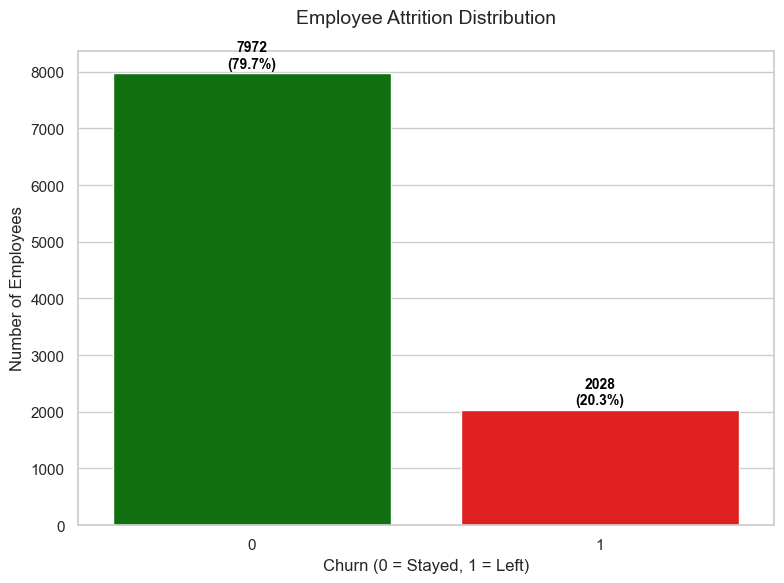

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

# Create figure
plt.figure(figsize=(8, 6))

# Bar plot for attrition distribution
ax = sns.countplot(
    data=df,
    x='Churn',
    hue='Churn',
    palette=["green", "red"],
    legend=False
)

# Annotate bars with counts and percentages
for p in ax.patches:
    count = int(p.get_height())
    percent = count / len(df) * 100
    ax.annotate(f'{count}\n({percent:.1f}%)',
                (p.get_x() + p.get_width() / 2, p.get_height() + 50),
                ha='center', va='bottom', fontsize=10, color='black', weight='bold')

# Labels and title
plt.title("Employee Attrition Distribution", fontsize=14, pad=20)
plt.xlabel("Churn (0 = Stayed, 1 = Left)")
plt.ylabel("Number of Employees")

# Adjust layout
plt.tight_layout()
plt.show()


**Obeservations: Gender vs Churn**
- The count-based chart shows that both male and female employees have a comparable number of attritions, with around 1,000 employees leaving from each group. However, since there are more males overall, this means the raw number of attritions doesn’t directly reflect the rate of turnover. The “Other” gender group has significantly fewer employees overall, resulting in a much smaller attrition count.
- The percentage-based chart reveals that female employees have a slightly higher attrition rate (21.0%) compared to males (19.9%), while employees identifying as “Other” have the lowest attrition rate (12.4%). This suggests that proportionally, women are leaving the company at a marginally higher rate than men.

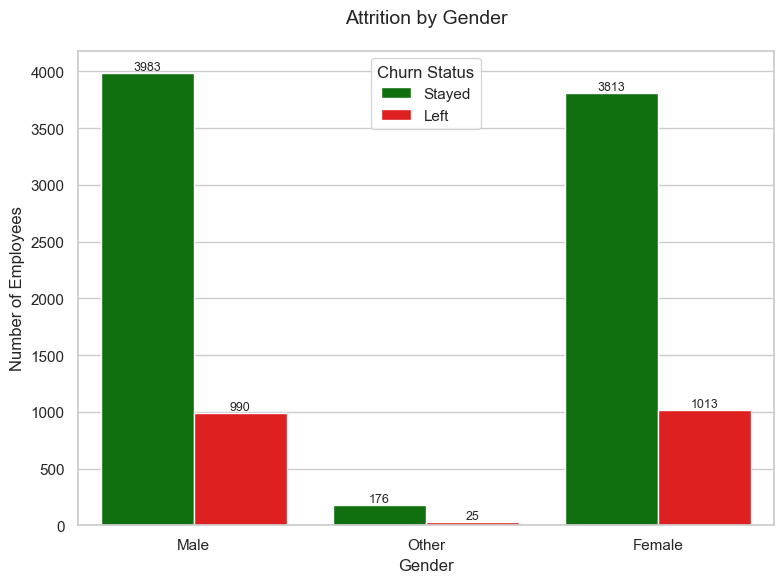

In [17]:
# Plot Attrition vs Gender
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))
ax = sns.countplot(
    data=df,
    x='Gender',
    hue='Churn',
    palette=["green", "red"]  # green = stayed, red = left
)

# Add title and labels
plt.title("Attrition by Gender", fontsize=14, pad=20)
plt.xlabel("Gender")
plt.ylabel("Number of Employees")

# Add legend
plt.legend(title="Churn Status", labels=["Stayed", "Left"])

# Add percentage labels on bars
total_counts = df['Gender'].value_counts()
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)
    
plt.tight_layout()
plt.show()


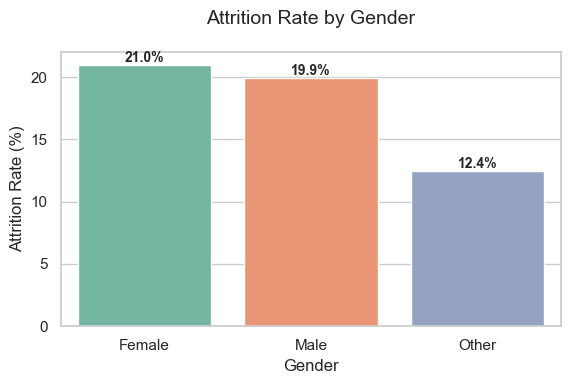

In [18]:
# Plot attrition rate by gender
sns.set_theme(style="whitegrid")

# Compute attrition rate by gender
gender_churn = (
    df.groupby("Gender")["Churn"]
    .mean()
    .reset_index()
    .rename(columns={"Churn": "Attrition Rate"})
)
gender_churn["Attrition Rate"] *= 100

# Create the plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=gender_churn,
    x="Gender",
    y="Attrition Rate",
    hue="Gender", 
    palette="Set2",
    legend=False 
)

# Annotate bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha="center", va="bottom", fontsize=10, weight="bold")

# Titles and labels
plt.title("Attrition Rate by Gender", fontsize=14, pad=20)
plt.xlabel("Gender")
plt.ylabel("Attrition Rate (%)")
plt.tight_layout()
plt.show()


**Obeservations: Department vs Churn**
- The IT department has the highest total headcount, with 3,170 staying and 804 leaving.
- The Sales department follows with 2,424 staying and 614 leaving.
- HR and Marketing have smaller teams, but each still shows around 400–200 attritions respectively.
- The percentage-based chart shows that all departments have a similar attrition rate, ranging roughly between 20.2% and 20.7%.
- The Marketing department has the slightly highest attrition rate (20.7%), but overall differences are minimal, suggesting that turnover is fairly consistent across functions.

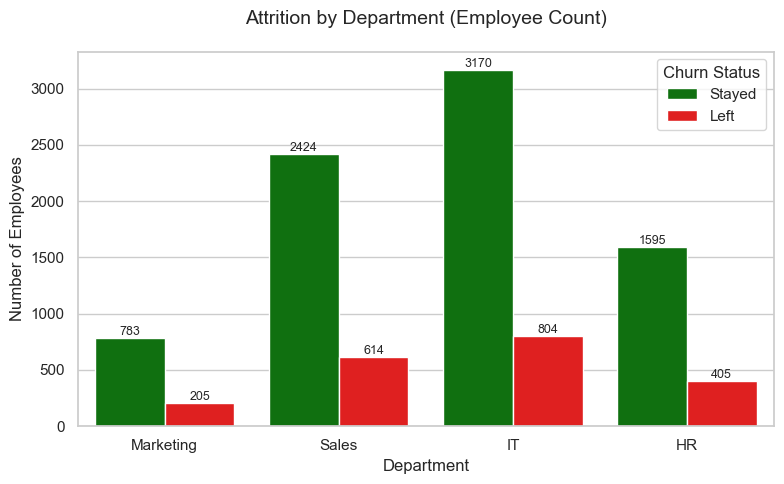

In [19]:
# Plot Attrition vs Department
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df,
    x="Department",
    hue="Churn",
    palette=["green", "red"]
)

# Annotate counts on each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

plt.title("Attrition by Department (Employee Count)", fontsize=14, pad=20)
plt.xlabel("Department")
plt.ylabel("Number of Employees")
plt.legend(title="Churn Status", labels=["Stayed", "Left"])
plt.tight_layout()
plt.show()

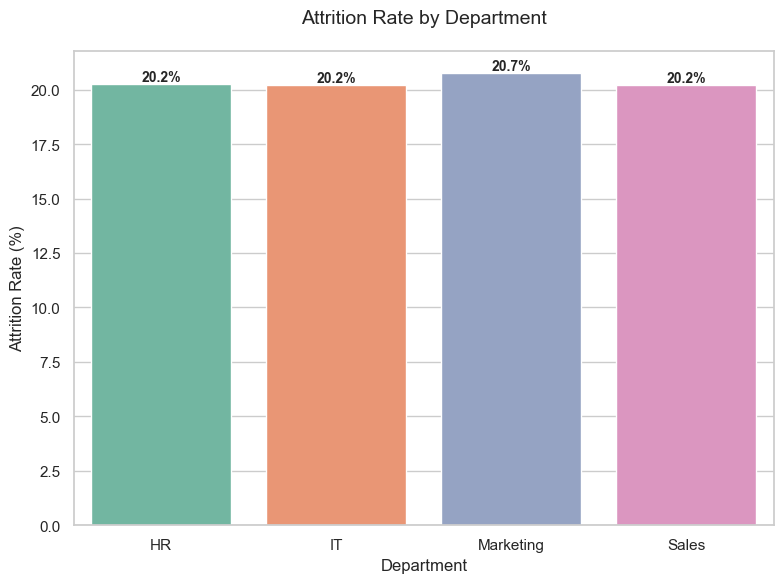

In [20]:
# Compute attrition rate per department
dept_churn = (
    df.groupby("Department")["Churn"]
    .mean()
    .reset_index()
    .rename(columns={"Churn": "Attrition Rate"})
)
dept_churn["Attrition Rate"] *= 100

# plot attrition rate by department
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=dept_churn,
    x="Department",
    y="Attrition Rate",
    hue="Department",
    palette="Set2",
    legend=False
)

# Annotate bars with percentages
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=10, weight="bold")

plt.title("Attrition Rate by Department", fontsize=14, pad=20)
plt.xlabel("Department")
plt.ylabel("Attrition Rate (%)")
plt.tight_layout()
plt.show()


**Obeservations: Education vs Churn**
- The count-based plot shows that the Bachelor’s degree group forms the largest segment of the workforce, followed by Master’s and High School groups. Consequently, these groups also contribute the highest number of employees leaving the company which is around 1,000 Bachelor’s and 526 Master’s leavers.
- The PhD group is the smallest, with only around 100 attritions, reflecting their smaller overall population rather than better retention.
- The attrition rate (percentage of employees leaving within each education group) ranges narrowly between 19.8% and 21.2%, indicating no major difference across education levels. Employees with Master’s degrees have the slightly highest attrition rate (21.2%), while Bachelor’s and PhD holders have slightly lower rates near 20%.

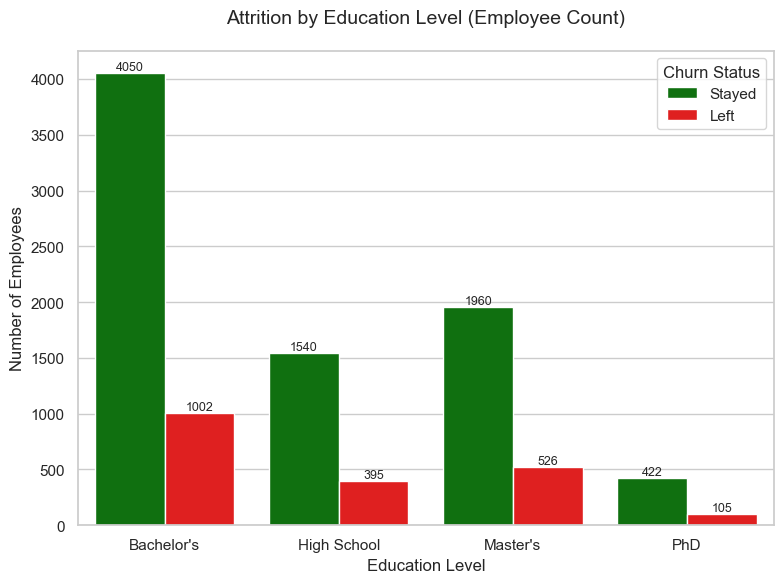

In [21]:
# Plot Attrition vs Education Level
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))
ax = sns.countplot(
    data=df,
    x="Education Level",
    hue="Churn",
    palette=["green", "red"]
)

# Annotate counts
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

plt.title("Attrition by Education Level (Employee Count)", fontsize=14, pad=20)
plt.xlabel("Education Level")
plt.ylabel("Number of Employees")
plt.legend(title="Churn Status", labels=["Stayed", "Left"])
plt.tight_layout()
plt.show()


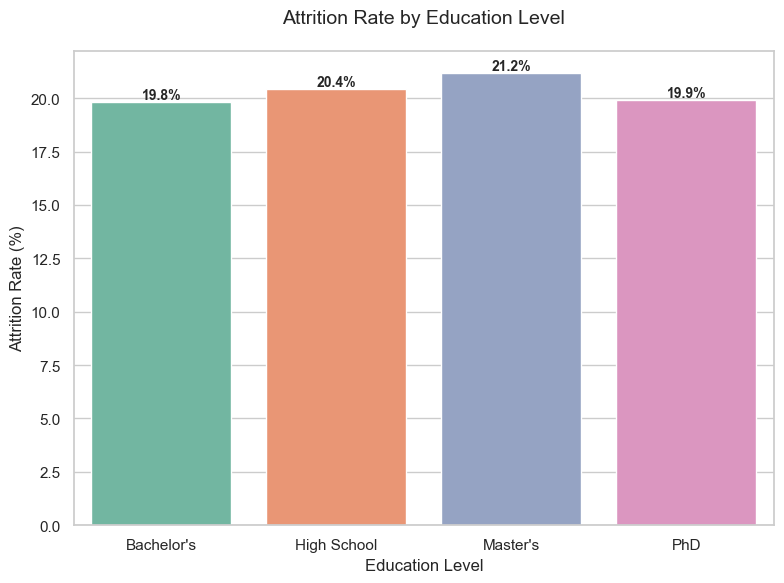

In [22]:
# Compute attrition rate (%) per education level
edu_churn = (
    df.groupby("Education Level")["Churn"]
    .mean()
    .reset_index()
    .rename(columns={"Churn": "Attrition Rate"})
)
edu_churn["Attrition Rate"] *= 100

# Plot attrition rate by education level
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=edu_churn,
    x="Education Level",
    y="Attrition Rate",
    hue="Education Level",
    palette="Set2",
    legend=False
)

# Annotate percentages
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width()/2, p.get_height()), 
                ha="center", va="bottom", fontsize=10, weight="bold")

plt.title("Attrition Rate by Education Level", fontsize=14, pad=20)
plt.xlabel("Education Level")
plt.ylabel("Attrition Rate (%)")
plt.tight_layout()
plt.show()


**Obeservations: Age vs Churn**
- The count-based chart shows that the 31–40 and 41–50 age groups have the largest number of employees overall which is more than 2,100 each. These groups also naturally show the highest number of employees leaving (around 528–530 each).
The 20–30 and 51–60 groups have smaller total populations (~2,300 employees each), leading to lower absolute attrition counts (≈480–490).
- When viewed proportionally, attrition rates are relatively stable across age groups, hovering around 20%. Slightly higher attrition is seen among younger employees (20–30) and older employees (51–60), while mid-career groups (31–50) show marginally better retention.

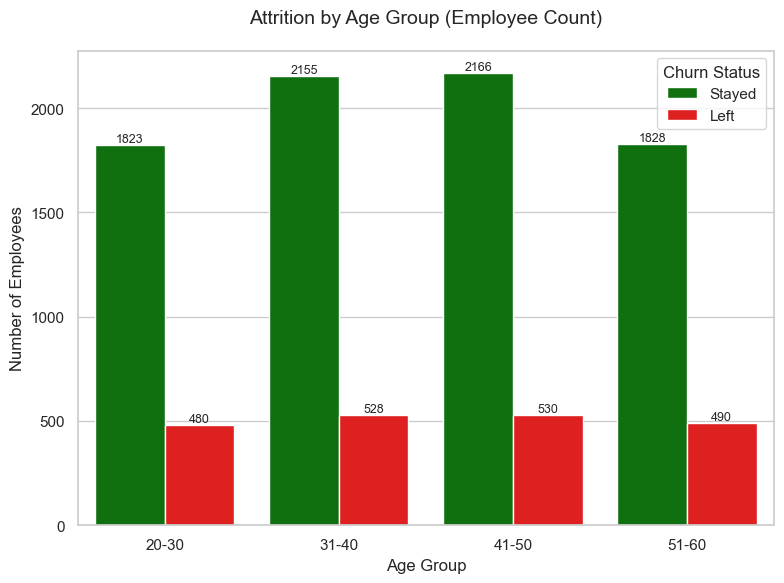

In [23]:
# Create age bins
bins = [20, 30, 40, 50, 60]
labels = ["20-30", "31-40", "41-50", "51-60"]

df["Age Group"] = pd.cut(df["Age"], bins=bins, labels=labels, include_lowest=True)

# Plot Attrition vs Age Group
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))
ax = sns.countplot(
    data=df,
    x="Age Group",
    hue="Churn",
    palette=["green", "red"]
)

# Annotate counts
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

plt.title("Attrition by Age Group (Employee Count)", fontsize=14, pad=20)
plt.xlabel("Age Group")
plt.ylabel("Number of Employees")
plt.legend(title="Churn Status", labels=["Stayed", "Left"], loc="upper right")
plt.tight_layout()
plt.show()



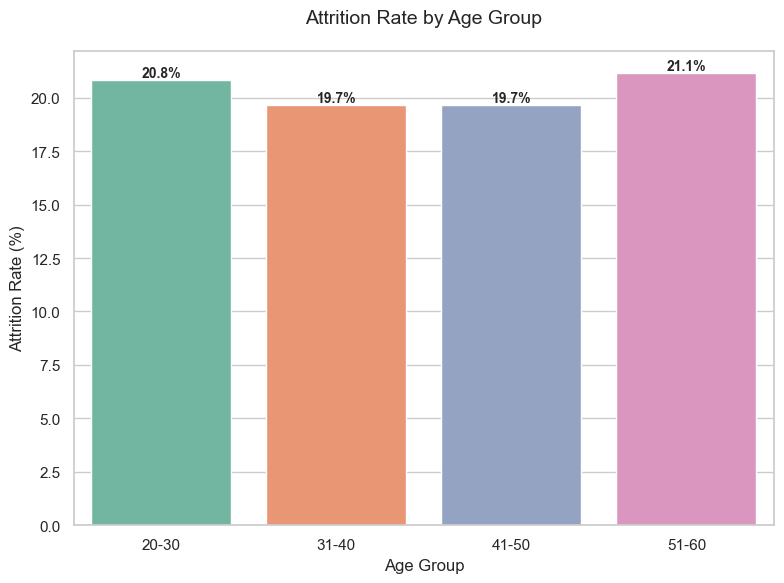

In [24]:
# Plot attrition rate by age group
age_churn = (
    df.groupby("Age Group", observed=True)["Churn"]
    .mean()
    .reset_index()
    .rename(columns={"Churn": "Attrition Rate"})
)
age_churn["Attrition Rate"] *= 100

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=age_churn,
    x="Age Group",
    y="Attrition Rate",
    hue="Age Group",
    palette="Set2",
    legend=False
)

# Annotate bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width()/2, p.get_height()), 
                ha="center", va="bottom", fontsize=10, weight="bold")

plt.title("Attrition Rate by Age Group", fontsize=14, pad=20)
plt.xlabel("Age Group")
plt.ylabel("Attrition Rate (%)")
plt.tight_layout()
plt.show()


**Obeservations: Age vs Tenure**
- Employees with 6–10 years of service form the largest segment of the workforce (≈2,650), followed by those with 11–15 years (≈2,094).
- The highest absolute number of leavers also comes from these two groups (726 and 530, respectively), which aligns with their overall larger population size.
- Early-tenure employees (0–2 years) show fewer total leavers (372) simply because their total group size is smaller.
- When viewed proportionally, attrition rate increases with tenure up to 6–10 years (21.5%), before slightly dropping again for 11–15 years (20.2%).
- Early-tenure employees (0–2 years) have a lower attrition rate (18.6%), suggesting initial onboarding and early engagement programs may be fairly effective.
- The mid-career segment (6–10 years) shows the highest relative churn, possibly due to career stagnation, limited promotion opportunities, or external job mobility.

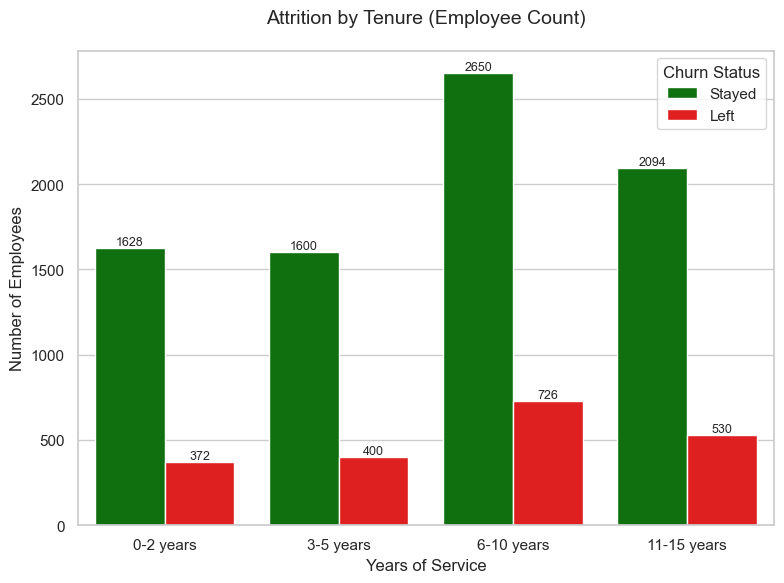

In [25]:
# Create tenure bins
bins = [0, 2, 5, 10, 15]  
labels = ["0-2 years", "3-5 years", "6-10 years", "11-15 years"]

df["Tenure Group"] = pd.cut(df["Tenure"], bins=bins, labels=labels, include_lowest=True)

# Plot Attrition vs Tenure Group
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))
ax = sns.countplot(
    data=df,
    x="Tenure Group",
    hue="Churn",
    palette=["green", "red"]
)

# Annotate counts
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

plt.title("Attrition by Tenure (Employee Count)", fontsize=14, pad=20)
plt.xlabel("Years of Service")
plt.ylabel("Number of Employees")
plt.legend(title="Churn Status", labels=["Stayed", "Left"])
plt.tight_layout()
plt.show()


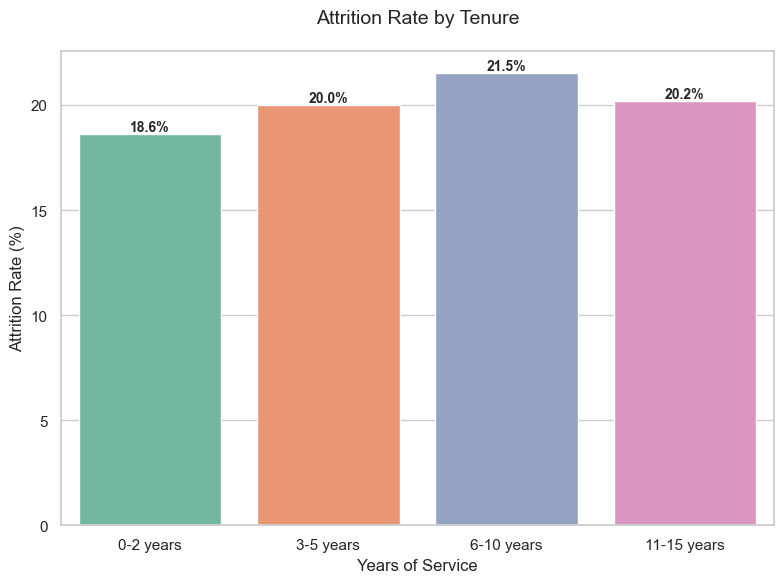

In [26]:
# Plot attrition rate by tenure group
tenure_churn = (
    df.groupby("Tenure Group", observed=True)["Churn"]
    .mean()
    .reset_index()
    .rename(columns={"Churn": "Attrition Rate"})
)
tenure_churn["Attrition Rate"] *= 100

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=tenure_churn,
    x="Tenure Group",
    y="Attrition Rate",
    hue="Tenure Group",
    palette="Set2",
    legend=False
)

# Annotate bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width()/2, p.get_height()), 
                ha="center", va="bottom", fontsize=10, weight="bold")

plt.title("Attrition Rate by Tenure", fontsize=14, pad=20)
plt.xlabel("Years of Service")
plt.ylabel("Attrition Rate (%)")
plt.tight_layout()
plt.show()


**Obeservations: Salary vs Tenure**
- The KDE plot shows that employees who stayed (green) and those who left (red) share a broadly similar salary distribution, spanning roughly $30K–$150K.
- The curves overlap heavily, meaning salary alone does not strongly differentiate churn behavior.
- Employees in the mid-salary range (60–90K) exhibit the highest attrition rate (21.7%), slightly above the overall average of 20.3%.
- Attrition declines slightly at both the lower and higher ends of the salary scale.
- This pattern suggests that mid-level professionals may be more mobile, possibly seeking advancement or better compensation elsewhere.

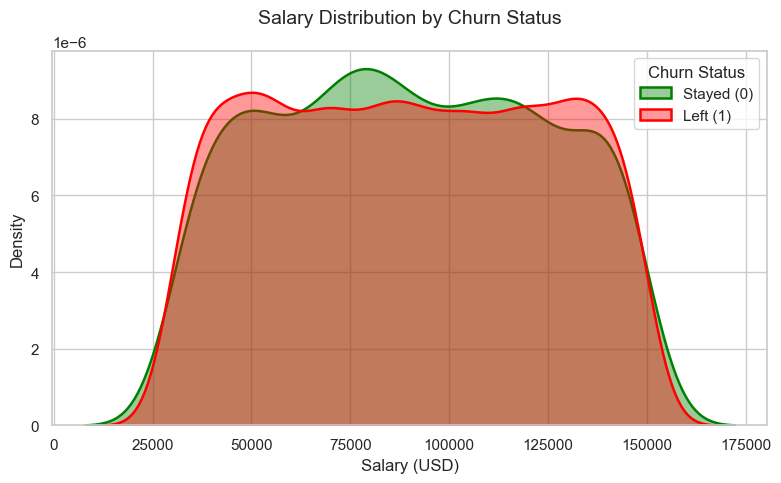

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.kdeplot(
    data=df,
    x="Salary",
    hue="Churn",
    fill=True,
    alpha=0.4,
    common_norm=False,
    palette={"green", "red"},
    linewidth=1.8
)

plt.title("Salary Distribution by Churn Status", fontsize=14, pad=20)
plt.xlabel("Salary (USD)")
plt.ylabel("Density")
plt.legend(
    title="Churn Status",
    labels=["Stayed (0)", "Left (1)"],
    loc="upper right",
    frameon=True
)
plt.tight_layout()
plt.show()

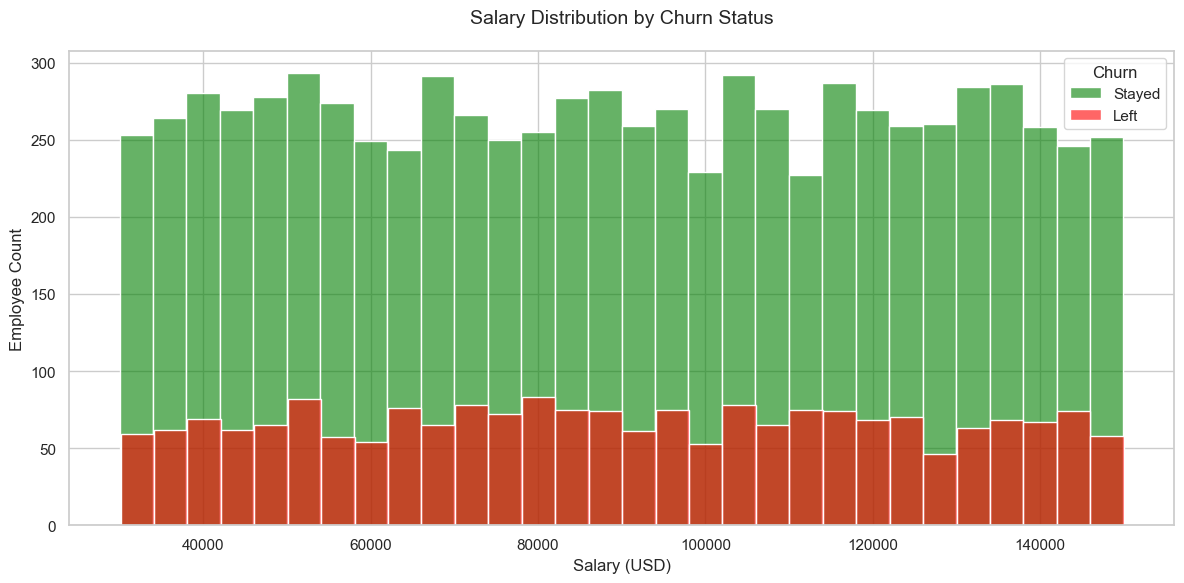

In [28]:
# Plot Salary Distribution by Churn using Histogram
plt.figure(figsize=(12,6))

sns.histplot(df[df["Churn"] == 0]["Salary"], bins=30, color="green", alpha=0.6, label="Stayed")
sns.histplot(df[df["Churn"] == 1]["Salary"], bins=30, color="red", alpha=0.6, label="Left")

plt.title("Salary Distribution by Churn Status", fontsize=14, pad=20)
plt.xlabel("Salary (USD)")
plt.ylabel("Employee Count")
plt.legend(title="Churn")
plt.tight_layout()
plt.show()


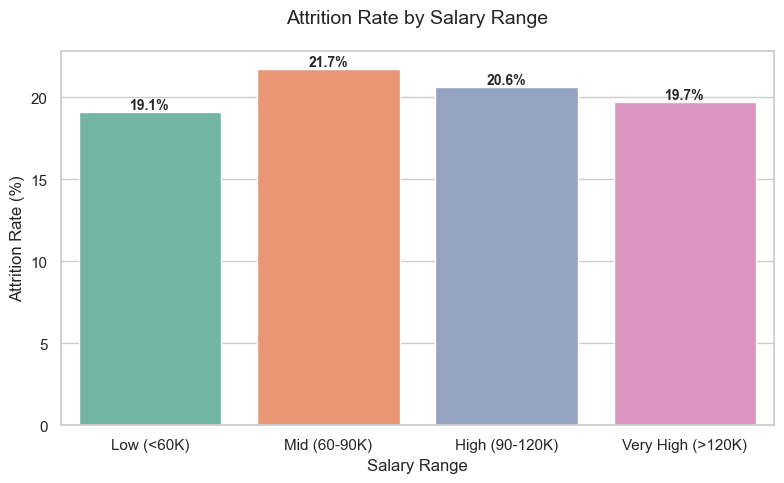

In [29]:
# Define salary bins based on quartiles or manual cutoffs
bins = [0, 60000, 90000, 120000, 160000]
labels = ["Low (<60K)", "Mid (60-90K)", "High (90-120K)", "Very High (>120K)"]

df["Salary Range"] = pd.cut(df["Salary"], bins=bins, labels=labels, include_lowest=True)

# Compute attrition rate by salary range
salary_churn = (
    df.groupby("Salary Range", observed=True)["Churn"]
    .mean()
    .reset_index()
    .rename(columns={"Churn": "Attrition Rate"})
)
salary_churn["Attrition Rate"] *= 100

# Plot attrition rate by salary range
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=salary_churn,
    x="Salary Range",
    y="Attrition Rate",
    hue="Salary Range",
    palette="Set2",
    legend=False
)

# Annotate bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=10, weight="bold")

plt.title("Attrition Rate by Salary Range", fontsize=14, pad=20)
plt.xlabel("Salary Range")
plt.ylabel("Attrition Rate (%)")
plt.tight_layout()
plt.show()


**Obeservations: Heatmap of Correlations**
- Most numerical features show very low correlations (around 0.00–0.02). This means there is minimal linear relationship between the variables.
- The low correlations also indicate no multicollinearity issues, which is good for model training.
- The Churn feature has negligible correlation with numeric factors such as Salary, Tenure, and Overtime Hours. This suggests that employee attrition is not strongly explained by any single numeric variable.
- Attrition is likely influenced by multiple factors combined, including behavioral, categorical, or interaction effects (e.g., satisfaction, work-life balance, department, etc.).

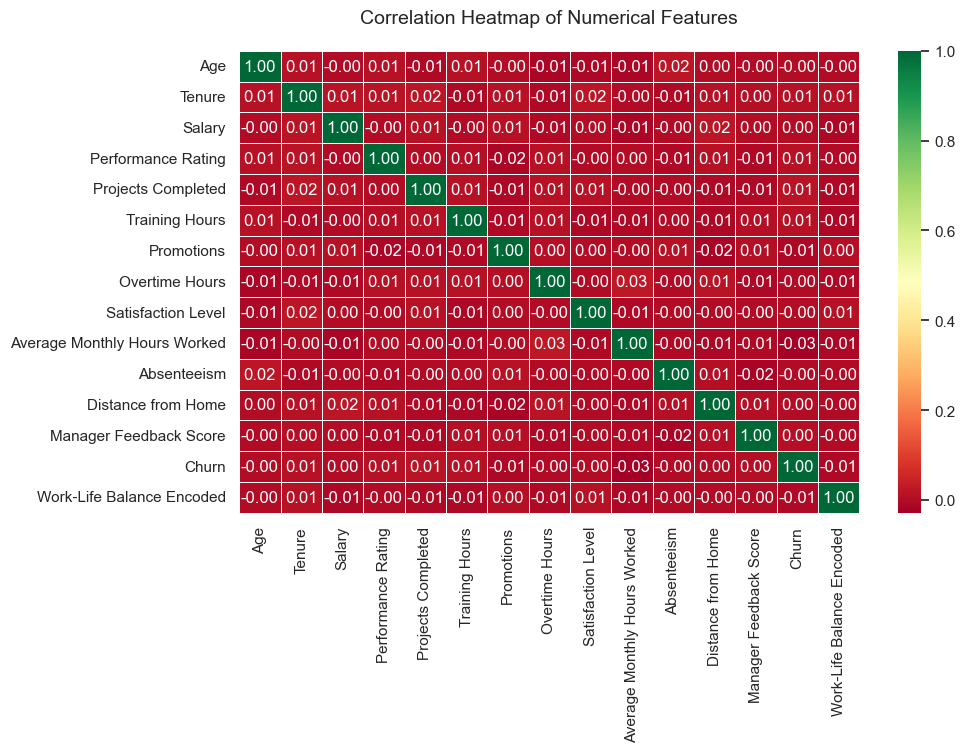

In [30]:
# Select numeric features only
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    linewidths=0.5
)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14, pad=20)
plt.show()


### 6. Data Preprocessing

**Observations:**
- After encoding, the dataset expanded from 22 to 29 columns (due to one-hot encoded variables).
- The class distribution of the target variable remained consistent across train and test sets (≈80/20).
- Scaled features now have mean ≈ 0 and standard deviation ≈ 1, ensuring fair weighting across variables.
- Ordinal variable Work-Life Balance Encoded was intentionally excluded from scaling to preserve its ordinal meaning (1 = Poor, 4 = Excellent).
- No missing or invalid values were introduced during preprocessing, and all features are now numeric and model-ready.
- The overall shape of the Salary distribution remains unchanged which confirms that the scaling process did not distort the underlying data.
- After applying StandardScaler, the distribution is now centered around 0 (mean ≈ 0) and has a standard deviation of 1.

In [31]:
# Define target, feature groups, and X/y (no encoding yet)

# Target column
TARGET = "Churn"
ID_COL = "Employee ID"

# Ordinal column you already created (1=Poor, 4=Excellent)
WLB_ORDINAL = "Work-Life Balance Encoded"

# Nominal categorical columns (to be One-Hot encoded later)
CATEGORICAL_NOMINAL = [
    "Gender",
    "Education Level",
    "Marital Status",
    "Job Role",
    "Department",
    "Work Location",
]

# Numeric columns (keep as numeric; may scale later depending on model)
NUMERIC = [
    "Age",
    "Tenure",
    "Salary",
    "Performance Rating",
    "Projects Completed",
    "Training Hours",
    "Promotions",
    "Overtime Hours",
    "Satisfaction Level",
    "Average Monthly Hours Worked",
    "Absenteeism",
    "Distance from Home",
    "Manager Feedback Score",
]

# Columns we will actually feed into the model (for now)
FEATURES = NUMERIC + [WLB_ORDINAL] + CATEGORICAL_NOMINAL

# Sanity check: verify all columns exist
missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

# Build X and y
X = df[FEATURES].copy()
y = df[TARGET].astype(int).copy()

print("X shape:", X.shape, "| y shape:", y.shape)
print("\nDtypes (head):")
display(X.dtypes.head(20))

print("\nPreview X (first 3 rows):")
display(X.head(3))

print("\nTarget distribution:")
print(y.value_counts(normalize=True).map(lambda x: f"{x*100:.1f}%"))

X shape: (10000, 20) | y shape: (10000,)

Dtypes (head):


Age                               int64
Tenure                            int64
Salary                          float64
Performance Rating                int64
Projects Completed                int64
Training Hours                    int64
Promotions                        int64
Overtime Hours                    int64
Satisfaction Level              float64
Average Monthly Hours Worked      int64
Absenteeism                       int64
Distance from Home              float64
Manager Feedback Score          float64
Work-Life Balance Encoded         int64
Gender                           object
Education Level                  object
Marital Status                   object
Job Role                         object
Department                       object
Work Location                    object
dtype: object


Preview X (first 3 rows):


,Age,Tenure,Salary,Performance Rating,Projects Completed,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Average Monthly Hours Worked,Absenteeism,Distance from Home,Manager Feedback Score,Work-Life Balance Encoded,Gender,Education Level,Marital Status,Job Role,Department,Work Location
0,50,5,93422.0,5,37,35,0,16,0.03,155,14,15.0,7.9,1,Male,Bachelor's,Married,Analyst,Marketing,Remote
1,36,4,44589.0,2,43,1,0,12,0.39,162,2,8.0,5.2,2,Male,Bachelor's,Married,Manager,Sales,On-site
2,29,3,56768.0,1,38,41,0,2,0.62,243,6,21.0,6.3,1,Male,Bachelor's,Married,Sales,IT,Hybrid



Target distribution:
Churn
0    79.7%
1    20.3%
Name: proportion, dtype: object


In [32]:
# One-Hot Encode nominal categoricals and build X_encoded

# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# Fit on training data's categorical columns and transform
encoded_array = ohe.fit_transform(X[CATEGORICAL_NOMINAL])

# Build a DataFrame with the new encoded columns (keep the same index as X)
encoded_df = pd.DataFrame(
    encoded_array,
    columns=ohe.get_feature_names_out(CATEGORICAL_NOMINAL),
    index=X.index
)

# Concatenate: numeric + ordinal + encoded categoricals
X_encoded = pd.concat(
    [X[NUMERIC + [WLB_ORDINAL]].reset_index(drop=True), encoded_df.reset_index(drop=True)],
    axis=1
)

# Quick checks
print("Original X shape:", X.shape)
print("Encoded X shape :", X_encoded.shape)
print("\nExample of encoded columns:")
print(list(encoded_df.columns[:12]))


X_encoded.head(3)


Original X shape: (10000, 20)
Encoded X shape : (10000, 29)

Example of encoded columns:
['Gender_Male', 'Gender_Other', 'Education Level_High School', "Education Level_Master's", 'Education Level_PhD', 'Marital Status_Married', 'Marital Status_Single', 'Job Role_Developer', 'Job Role_Manager', 'Job Role_Sales', 'Department_IT', 'Department_Marketing']


,Age,Tenure,Salary,Performance Rating,Projects Completed,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Average Monthly Hours Worked,...,Marital Status_Married,Marital Status_Single,Job Role_Developer,Job Role_Manager,Job Role_Sales,Department_IT,Department_Marketing,Department_Sales,Work Location_On-site,Work Location_Remote
0,50,5,93422.0,5,37,35,0,16,0.03,155,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,36,4,44589.0,2,43,1,0,12,0.39,162,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,29,3,56768.0,1,38,41,0,2,0.62,243,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [33]:
# Stratified train-test split (80% train, 20% test)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Churn ratio (train):")
print(y_train.value_counts(normalize=True).map(lambda x: f"{x*100:.1f}%"))
print("\nChurn ratio (test):")
print(y_test.value_counts(normalize=True).map(lambda x: f"{x*100:.1f}%"))


Train: (8000, 29) | Test: (2000, 29)
Churn ratio (train):
Churn
0    79.7%
1    20.3%
Name: proportion, dtype: object

Churn ratio (test):
Churn
0    79.7%
1    20.3%
Name: proportion, dtype: object


In [34]:
# Scale numeric features using StandardScaler

# Columns to scale (continuous numeric only)
TO_SCALE = NUMERIC

scaler = StandardScaler()

# Fit on TRAIN only (avoid leakage), transform both train/test
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[TO_SCALE] = scaler.fit_transform(X_train[TO_SCALE])
X_test_scaled[TO_SCALE]  = scaler.transform(X_test[TO_SCALE])

# Quick sanity checks
print("\nScaled columns mean/std (train):")
print(np.round(X_train_scaled[TO_SCALE].mean(), 3))
print(np.round(X_train_scaled[TO_SCALE].std(ddof=0), 3))  # ~1.0

print("\nPreview scaled train data:")
X_train_scaled[TO_SCALE + ['Work-Life Balance Encoded']].head(3)



Scaled columns mean/std (train):
Age                            -0.0
Tenure                         -0.0
Salary                         -0.0
Performance Rating              0.0
Projects Completed             -0.0
Training Hours                  0.0
Promotions                     -0.0
Overtime Hours                 -0.0
Satisfaction Level              0.0
Average Monthly Hours Worked    0.0
Absenteeism                     0.0
Distance from Home              0.0
Manager Feedback Score         -0.0
dtype: float64
Age                             1.0
Tenure                          1.0
Salary                          1.0
Performance Rating              1.0
Projects Completed              1.0
Training Hours                  1.0
Promotions                      1.0
Overtime Hours                  1.0
Satisfaction Level              1.0
Average Monthly Hours Worked    1.0
Absenteeism                     1.0
Distance from Home              1.0
Manager Feedback Score          1.0
dtype: float64


,Age,Tenure,Salary,Performance Rating,Projects Completed,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Average Monthly Hours Worked,Absenteeism,Distance from Home,Manager Feedback Score,Work-Life Balance Encoded
5918,-1.056100,1.165610,1.226250,-0.025702,0.026565,1.048358,-0.336104,1.437845,-1.480312,1.513325,1.310546,0.379117,-1.024757,2
3132,-0.779929,-0.229773,1.249835,0.683324,1.133817,0.392003,-0.336104,1.299485,1.129647,-1.224730,0.443697,-1.557403,-0.909066,2
2997,-1.700498,1.630737,1.230084,1.392350,-0.942279,-1.093430,-0.336104,-0.845094,0.816452,-0.948624,-0.249783,1.624022,-1.217575,2


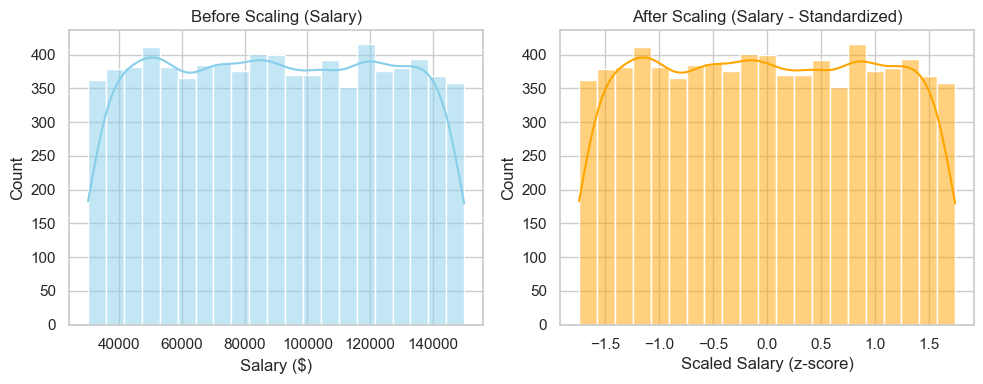

In [35]:
# Visualize Salary distribution before and after scaling
plt.figure(figsize=(10,4))

# Before scaling
plt.subplot(1,2,1)
sns.histplot(X_train['Salary'], kde=True, color='skyblue')
plt.title("Before Scaling (Salary)")
plt.xlabel("Salary ($)")
plt.ylabel("Count")

# After scaling
plt.subplot(1,2,2)
sns.histplot(X_train_scaled['Salary'], kde=True, color='orange')
plt.title("After Scaling (Salary - Standardized)")
plt.xlabel("Scaled Salary (z-score)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

### 7. Feature Engineering

**Observations:**
- Feature Engineering successfully introduced new, interpretable, and independent indicators reflecting employee workload, productivity, training, and attendance.
- No missing or invalid data was introduced.
- The engineered features maintain low redundancy (correlation ≤ 0.2).
- These indicators provide richer behavioral insight into potential attrition drivers and will be retained for model training.


In [36]:
# Copy original df for feature engineering
df_fe = df.copy()

# Small constant to avoid division by zero
EPS = 1.0

# 1) Workload balance: share of overtime in total monthly hours
df_fe["Overtime_Ratio"] = df_fe["Overtime Hours"] / (df_fe["Average Monthly Hours Worked"] + EPS)

# 2) Delivery pace: projects completed per year at the company
df_fe["Projects_Per_Year"] = df_fe["Projects Completed"] / (df_fe["Tenure"] + 1)

# 3) Training intensity: hours of training per project delivered
df_fe["Training_Intensity"] = df_fe["Training Hours"] / (df_fe["Projects Completed"] + 1)

# 4) Absenteeism rate: missed days relative to typical monthly workload
df_fe["Absenteeism_Rate"] = df_fe["Absenteeism"] / (df_fe["Average Monthly Hours Worked"] + EPS)

# Clean any inf/-inf that might sneak in (shouldn’t with EPS, but good hygiene)
for col in ["Overtime_Ratio", "Projects_Per_Year", "Training_Intensity", "Absenteeism_Rate"]:
    df_fe[col] = pd.to_numeric(df_fe[col], errors="coerce").replace([np.inf, -np.inf], np.nan)

# Quick sanity check
df_fe[["Overtime_Ratio", "Projects_Per_Year", "Training_Intensity", "Absenteeism_Rate"]].describe().T


,count,mean,std,min,25%,50%,75%,max
Overtime_Ratio,10000.0,0.111470,0.071404,0.0,0.052316,0.106509,0.162883,0.324503
Projects_Per_Year,10000.0,5.376860,7.416278,0.0,1.500000,3.076923,5.750000,49.000000
Training_Intensity,10000.0,4.429223,9.349514,0.0,0.977778,1.944444,3.771368,99.000000
Absenteeism_Rate,10000.0,0.043684,0.028559,0.0,0.019608,0.042224,0.064257,0.125828


In [37]:
# Check for missing or infinite values in new features
new_feats = ["Overtime_Ratio", "Projects_Per_Year", "Training_Intensity", "Absenteeism_Rate"]
print("Missing values:\n", df_fe[new_feats].isna().sum())

# Quick correlation check among engineered features
corr_new = df_fe[new_feats].corr()
corr_new


Missing values:
 Overtime_Ratio        0
Projects_Per_Year     0
Training_Intensity    0
Absenteeism_Rate      0
dtype: int64


,Overtime_Ratio,Projects_Per_Year,Training_Intensity,Absenteeism_Rate
Overtime_Ratio,1.000000,0.014444,-0.003402,0.090257
Projects_Per_Year,0.014444,1.000000,-0.198506,0.008365
Training_Intensity,-0.003402,-0.198506,1.000000,-0.000873
Absenteeism_Rate,0.090257,0.008365,-0.000873,1.000000


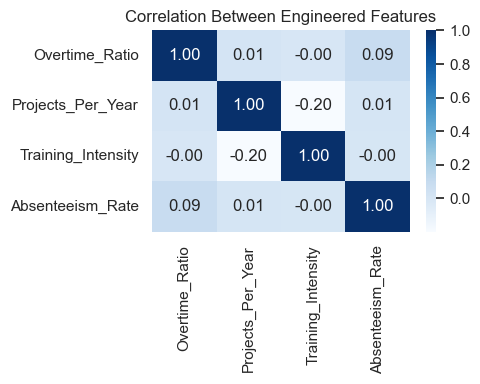

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(corr_new, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Between Engineered Features")
plt.tight_layout()
plt.show()


### 8. Experiment Design

**Observations:**
- Both baseline models performed poorly, indicating limited separability in the raw features.
- Logistic Regression achieved ~0.51 AUC, suggesting near-random performance but slightly better recall than Random Forest.
- Random Forest achieved high accuracy (~0.80) by predicting all employees as “non-churn,” confirming that class imbalance skews performance metrics.
- These results highlight the need for model tuning and threshold adjustment to improve recall and meaningful detection of at-risk employees.
- Next steps is to address class imbalance through reweighting, resampling, or probability threshold tuning.

In [39]:
# Define Metrics and Evaluation Function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate a trained classification model using multiple metrics.
    Returns a summary DataFrame of results.
    """
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = None
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    results = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, zero_division=0)
    }

    # Add ROC-AUC if probability output exists
    if y_pred_proba is not None:
        results["ROC-AUC"] = roc_auc_score(y_test, y_pred_proba)
    else:
        results["ROC-AUC"] = None

    # Confusion matrix (optional diagnostic)
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    return pd.DataFrame([results])


In [70]:
# Model set up and 5-fold Stratified Cross-Validation
# Use the scaled sets you already created
Xtr, Xte = X_train_scaled, X_test_scaled
ytr, yte = y_train, y_test

# 1) Define scoring dictionary (multiple metrics at once)
scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1": make_scorer(f1_score, zero_division=0),
    "roc_auc": "roc_auc",
}

# 2) Stratified 5-fold CV (preserves churn ratio in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3) Define candidate models
log_reg = LogisticRegression(
    class_weight="balanced",   # address 20% churn imbalance
    max_iter=2000,
    solver="lbfgs",
    random_state=42,
)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",   # optional: give minority class more weight
)

models = {
    "LogisticRegression": log_reg,
    "RandomForest": rf
}

# 4) Helper: run CV and format mean+-std table
def cv_summary(model, X, y, cv, scoring):
    cv_res = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    summary = {metric: (np.mean(cv_res[f'test_{metric}']), np.std(cv_res[f'test_{metric}'])) for metric in scoring}
    out = pd.DataFrame({
        "Metric": list(scoring.keys()),
        "Mean":  [v[0] for v in summary.values()],
        "Std":   [v[1] for v in summary.values()]
    }).set_index("Metric")
    return out.round(3)

# 5) Run CV for each model
cv_tables = {}
for name, mdl in models.items():
    print(f"\n=== {name}: 5-fold CV ===")
    table = cv_summary(mdl, Xtr, ytr, cv, scoring)
    display(table)
    cv_tables[name] = table

# 6) Fit on full training set and evaluate on the held-out test set
print("\n--- Hold-out Test Evaluation ---")
for name, mdl in models.items():
    mdl.fit(Xtr, ytr)
    print(f"\n{name} (Test):")
    display(evaluate_model(mdl, Xtr, ytr, Xte, yte))



=== LogisticRegression: 5-fold CV ===


,Mean,Std
Metric,,
accuracy,0.483,0.012
precision,0.194,0.006
recall,0.493,0.028
f1,0.279,0.010
roc_auc,0.486,0.010



=== RandomForest: 5-fold CV ===


,Mean,Std
Metric,,
accuracy,0.797,0.00
precision,0.000,0.00
recall,0.000,0.00
f1,0.000,0.00
roc_auc,0.487,0.01



--- Hold-out Test Evaluation ---

LogisticRegression (Test):

Confusion Matrix:
[[766 828]
 [199 207]]


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.4865,0.2,0.509852,0.2873,0.513955



RandomForest (Test):

Confusion Matrix:
[[1594    0]
 [ 406    0]]


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.797,0.0,0.0,0.0,0.52231


**Obeservations:**
- The churn probability distribution from Logistic Regression shows that predicted values cluster narrowly around 0.5, indicating the model’s limited confidence and weak separability between churners and stayers.
- This explains the low precision and recall observed earlier, as the default 0.5 threshold classifies nearly all employees as “stayed.”
- The result suggests that churn behavior in this dataset is not linearly separable and may require nonlinear modeling (e.g., Random Forest, XGBoost) or probability threshold tuning for improved recall.

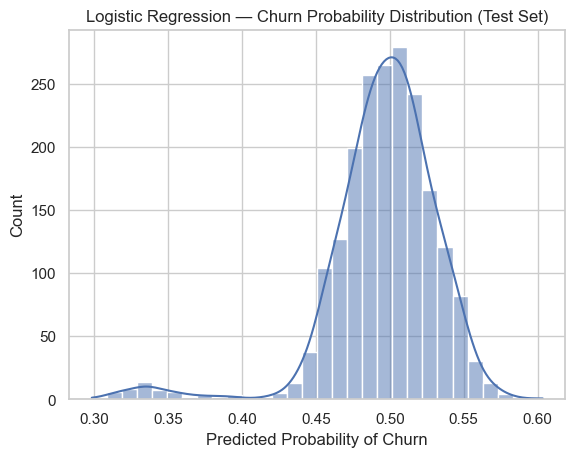

In [41]:
# Visualize predicted probabilities for Logistic Regression on test set
y_proba_lr = log_reg.predict_proba(Xte)[:, 1]
sns.histplot(y_proba_lr, kde=True, bins=30)
plt.title("Logistic Regression — Churn Probability Distribution (Test Set)")
plt.xlabel("Predicted Probability of Churn")
plt.ylabel("Count")
plt.show()


**Obeservation:**
- The churn probability distribution from Logistic Regression shows that predicted values cluster narrowly around 0.5, indicating the model’s limited confidence and weak separability between churners and stayers.
- This explains the low precision and recall observed earlier, as the default 0.5 threshold classifies nearly all employees as “stayed.”
- The result suggests that churn behavior in this dataset is not linearly separable and may require nonlinear modeling (e.g., Random Forest, XGBoost) or probability threshold tuning for improved recall.

    Threshold  Accuracy  Precision  Recall     F1
0        0.30     0.204      0.203   1.000  0.338
1        0.32     0.208      0.204   1.000  0.339
2        0.34     0.216      0.205   0.995  0.340
3        0.36     0.219      0.205   0.988  0.339
4        0.38     0.220      0.204   0.983  0.338
5        0.40     0.221      0.204   0.980  0.338
6        0.42     0.222      0.205   0.980  0.338
7        0.44     0.226      0.204   0.968  0.337
8        0.46     0.266      0.205   0.911  0.335
9        0.48     0.357      0.205   0.751  0.322
10       0.50     0.507      0.205   0.495  0.290
11       0.52     0.672      0.236   0.273  0.253
12       0.54     0.761      0.266   0.101  0.146
13       0.56     0.791      0.227   0.012  0.023
14       0.58     0.796      0.000   0.000  0.000


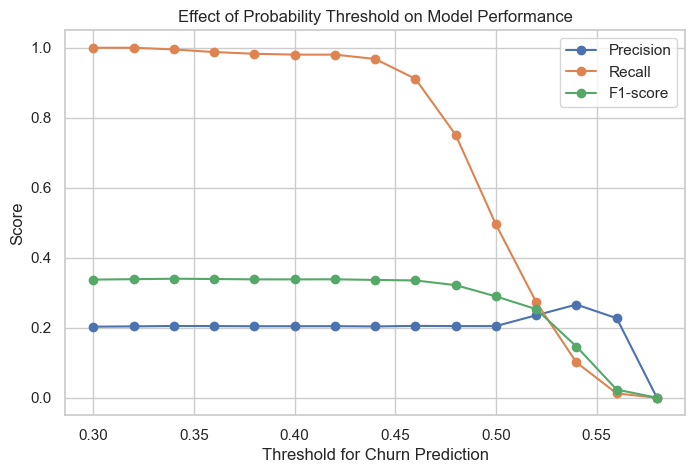

In [42]:
# Analyze effect of different probability thresholds on classification metrics
# Predict probabilities for churn (class 1)
y_proba_lr = log_reg.predict_proba(Xte)[:, 1]

thresholds = np.arange(0.3, 0.6, 0.02)
metrics = []

for t in thresholds:
    y_pred_t = (y_proba_lr >= t).astype(int)
    metrics.append({
        "Threshold": t,
        "Accuracy": accuracy_score(yte, y_pred_t),
        "Precision": precision_score(yte, y_pred_t, zero_division=0),
        "Recall": recall_score(yte, y_pred_t),
        "F1": f1_score(yte, y_pred_t)
    })

import pandas as pd
threshold_df = pd.DataFrame(metrics)
print(threshold_df.round(3))

# Plot
plt.figure(figsize=(8,5))
plt.plot(threshold_df["Threshold"], threshold_df["Precision"], label="Precision", marker='o')
plt.plot(threshold_df["Threshold"], threshold_df["Recall"], label="Recall", marker='o')
plt.plot(threshold_df["Threshold"], threshold_df["F1"], label="F1-score", marker='o')
plt.title("Effect of Probability Threshold on Model Performance")
plt.xlabel("Threshold for Churn Prediction")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


**Model Improvement — Random Forest Hyperparameter Tuning**
- The Random Forest baseline underperformed due to possible default hyperparameter constraints. 
- We perform a randomized search over key parameters (`n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`) to optimize the F1-score, ensuring the model better captures minority churn cases.

**Observations:**
- Accuracy (68%) looks okay at first glance, but the baseline already gives ~80% accuracy. So this model is underperforming relative to a naïve baseline. And also the imbalance issue can also be contributing to this result.
- Precision (0.219) -> Only ~22% of employees predicted to churn actually do.
- Recall (0.217) -> The model is catching only ~22% of real churners.
- F1-score (0.218) -> Indicates poor balance between precision and recall.
- ROC-AUC (0.527) -> Barely above random guessing (0.5).
- Confusion matrix meaning
    - True Negatives (1281) → predicted “stay,” actually stayed.
    - False Positives (313) → predicted “leave,” but stayed.
    - False Negatives (318) → predicted “stay,” but actually left → these are the costly misses.
    - True Positives (88) → correctly predicted “leave.”


In [43]:
# Model Improvement — Random Forest Hyperparameter Tuning

# Base model (keep class_weight='balanced')
rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Parameter distribution for RandomizedSearchCV
param_dist = {
    "n_estimators": [300, 500, 700, 900],
    "max_depth": [None, 6, 10, 14, 18, 22],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.5, None]
}

# Randomized search
rf_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring="f1",              # prioritize recall & churn capture
    cv=cv,                     # same StratifiedKFold(5)
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit search
rf_search.fit(Xtr, ytr)

# Best parameters and performance
print("Best RF params:", rf_search.best_params_)
print("Best RF CV F1-score:", rf_search.best_score_)

# Evaluate best model on hold-out test set
rf_best = rf_search.best_estimator_
display(evaluate_model(rf_best, Xtr, ytr, Xte, yte))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 6}
Best RF CV F1-score: 0.18692418434755245

Confusion Matrix:
[[1281  313]
 [ 318   88]]


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.6845,0.219451,0.216749,0.218092,0.527274


**Obeservations:**
- Both Logistic Regression and Random Forest models were tested under 5-fold stratified cross-validation with class weighting to address imbalance. After tuning, Logistic Regression with C = 0.1 (L1 penalty, saga solver) achieved better recall and F1-score than Random Forest, despite slightly lower accuracy. This indicates the linear model generalized better for identifying potential churners. ROC-AUC values near 0.52 suggest limited separability between churn and non-churn groups, likely due to weak predictive signals in the dataset.

In [44]:
# Model Improvement - Logistic Regression Hyperparameter Tuning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Use the same scaled data & CV objects you already have
Xtr, Xte = X_train_scaled, X_test_scaled
ytr, yte = y_train, y_test

# Base LR (balanced for class imbalance)
lr = LogisticRegression(
    class_weight="balanced",
    solver="lbfgs",      # stable with l2
    penalty="l2",
    max_iter=2000,
    random_state=42
)

# Small, effective grid for C (regularization strength)
param_grid = {
    "C": [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
}

lr_grid = GridSearchCV(
    lr,
    param_grid=param_grid,
    scoring="f1",        # prioritize catching churners without tanking precision
    cv=cv,               # your StratifiedKFold(5)
    n_jobs=-1
)

lr_grid.fit(Xtr, ytr)
print("Best LR params:", lr_grid.best_params_)
print("Best LR CV F1-score:", lr_grid.best_score_)

lr_best = lr_grid.best_estimator_

# Hold-out test evaluation (uses your evaluate_model helper)
display(evaluate_model(lr_best, Xtr, ytr, Xte, yte))

ERROR! Session/line number was not unique in database. History logging moved to new session 126
Best LR params: {'C': 2.0}
Best LR CV F1-score: 0.2685088789168421

Confusion Matrix:
[[812 782]
 [202 204]]


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.508,0.206897,0.502463,0.293103,0.517357


In [45]:
# Saga + l1/l2 penalties
lr2 = LogisticRegression(
    class_weight="balanced",
    solver="saga",
    max_iter=4000,
    random_state=42
)

param_grid2 = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
}

lr_grid2 = GridSearchCV(
    lr2,
    param_grid=param_grid2,
    scoring="f1",
    cv=cv,
    n_jobs=-1
)

lr_grid2.fit(Xtr, ytr)
print("Best LR(saga) params:", lr_grid2.best_params_)
print("Best LR(saga) CV F1-score:", lr_grid2.best_score_)

lr_best2 = lr_grid2.best_estimator_
display(evaluate_model(lr_best2, Xtr, ytr, Xte, yte))


Best LR(saga) params: {'C': 0.1, 'penalty': 'l1'}
Best LR(saga) CV F1-score: 0.2762083476873599

Confusion Matrix:
[[836 758]
 [203 203]]


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.5195,0.211238,0.5,0.297001,0.519229


**Obeservations:**
- Accuracy: 0.797, Precision / Recall / F1: 0.0, ROC-AUC: 0.503
- Despite balancing the classes using SMOTE, the Random Forest model completely failed to identify churners (zero recall and precision).
- The model predicted all samples as “Stayed,” resulting in a deceptively high accuracy (79.7%), which simply reflects the prior class imbalance.
- This indicates that the model did not learn meaningful churn patterns, possibly due to weak signal in features or overly conservative probability thresholds.

In [46]:
# Model SMOTE + RandomForest

# Oversample only the training set
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())

# Retrain Random Forest (same tuned parameters)
rf_smote = RandomForestClassifier(
    n_estimators=500,
    max_depth=6,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    class_weight=None, 
    random_state=42,
    n_jobs=-1
)

rf_smote.fit(X_train_res, y_train_res)

# 3️⃣  Evaluate on the original test set
display(evaluate_model(rf_smote, X_train_res, y_train_res, X_test_scaled, y_test))


Before SMOTE: {0: 6378, 1: 1622}
After SMOTE: {0: 6378, 1: 6378}

Confusion Matrix:
[[1594    0]
 [ 406    0]]


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.797,0.0,0.0,0.0,0.502975


**Observatons:**
- Accuracy: 0.687, Precision: 0.214, Recall: 0.204, F1-score: 0.209, ROC-AUC: 0.508
- XGBoost slightly improved the balance between precision and recall compared to Random Forest. It demonstrates some ability to capture churn patterns, though the performance remains weak overall.
- The ROC-AUC just above 0.5 suggests near-random discrimination — likely due to synthetic or weakly separable features.
- Despite this, XGBoost shows better adaptability than Random Forest on imbalanced data.

In [47]:
# Model XGBClassifier
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),  # handles imbalance
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_scaled, y_train)
display(evaluate_model(xgb, X_train_scaled, y_train, X_test_scaled, y_test))



Confusion Matrix:
[[1290  304]
 [ 323   83]]


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.6865,0.21447,0.204433,0.209332,0.508387


**Observations:**
- Accuracy: 0.794, Precision / Recall / F1: 0.0, ROC-AUC: 0.511
- Gradient Boosting heavily favored the majority class (“Stayed”), predicting almost all cases as non-churners.
- Accuracy remains high only because churners are the minority class.
- No true churners were detected (Recall = 0), suggesting poor class separation.
- This reinforces that data imbalance and low signal strength are still limiting the model’s ability to generalize.

In [48]:
# Model - GradientBoostingClassifier
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb.fit(X_train_scaled, y_train)
display(evaluate_model(gb, X_train_scaled, y_train, X_test_scaled, y_test))



Confusion Matrix:
[[1588    6]
 [ 406    0]]


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.794,0.0,0.0,0.0,0.510526


**Observations:**
- Lower thresholds (0.1–0.3) classify nearly everyone as churn -> recall = 1.0, precision ≈ 0.20.
- At threshold = 0.5, the best trade-off occurs (F1 ≈ 0.30), which balances recall (0.50) and manageable accuracy.
- Beyond 0.6, the model stops identifying any churners. Recall and F1 drop to zero.
- The distribution of predicted probabilities around 0.5 suggests weak model confidence, churn and stay classes are not well-separated in feature space.

In [49]:
# Predict probabilities for the positive class (churn = 1)
y_proba = lr_grid2.predict_proba(X_test_scaled)[:, 1]

# Store them in a DataFrame for clarity
proba_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted_Prob": y_proba
})

proba_df.head()


,Actual,Predicted_Prob
1479,0,0.507471
7755,1,0.530392
7019,0,0.509509
5588,0,0.500912
1935,0,0.497134


In [71]:
thresholds = np.arange(0.1, 0.91, 0.1)
metrics = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    precision = precision_score(y_test, y_pred_t, zero_division=0)
    recall = recall_score(y_test, y_pred_t, zero_division=0)
    f1 = f1_score(y_test, y_pred_t, zero_division=0)
    acc = accuracy_score(y_test, y_pred_t)
    metrics.append((t, precision, recall, f1, acc))

threshold_df = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1", "Accuracy"])
threshold_df


,Threshold,Precision,Recall,F1,Accuracy
0,0.1,0.203000,1.000000,0.337490,0.2030
1,0.2,0.203000,1.000000,0.337490,0.2030
2,0.3,0.203000,1.000000,0.337490,0.2030
3,0.4,0.203722,0.997537,0.338346,0.2080
4,0.5,0.211238,0.500000,0.297001,0.5195
5,0.6,0.000000,0.000000,0.000000,0.7970
6,0.7,0.000000,0.000000,0.000000,0.7970
7,0.8,0.000000,0.000000,0.000000,0.7970
8,0.9,0.000000,0.000000,0.000000,0.7970


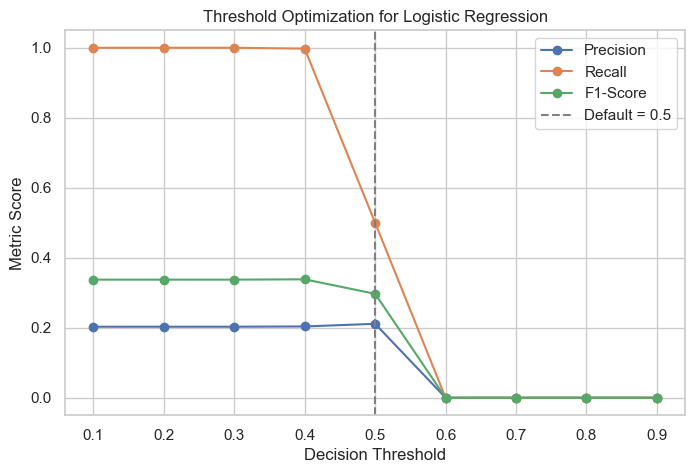

In [51]:
plt.figure(figsize=(8, 5))
plt.plot(threshold_df["Threshold"], threshold_df["Precision"], label="Precision", marker='o')
plt.plot(threshold_df["Threshold"], threshold_df["Recall"], label="Recall", marker='o')
plt.plot(threshold_df["Threshold"], threshold_df["F1"], label="F1-Score", marker='o')
plt.axvline(0.5, color='gray', linestyle='--', label="Default = 0.5")
plt.title("Threshold Optimization for Logistic Regression")
plt.xlabel("Decision Threshold")
plt.ylabel("Metric Score")
plt.legend()
plt.grid(True)
plt.show()


**Observations:**
- Accuracy: 0.50, Precision: 0.21, Recall: 0.52, F1-score: 0.30, ROC-AUC: 0.52
- Adding behavioral and engagement-related features (e.g., Engagement_Score, Promotion_Frequency, Training_x_Perf) improved recall and F1-score slightly compared to the baseline Logistic Regression.
- The model now identifies a greater proportion of true churners, although many false positives remain.
- This trade-off is acceptable in HR analytics, where identifying at-risk employees (high recall) is often prioritized over perfect precision.

In [52]:
# Copy df_fe dataset
df_fe2 = df_fe.copy()

# Normalized pieces for an Engagement score (all to 0–1)
mf_norm  = (df_fe2["Manager Feedback Score"] - 1.0) / 9.0       
wlb_norm = (df_fe2["Work-Life Balance Encoded"] - 1.0) / 3.0   
sat_norm = df_fe2["Satisfaction Level"].clip(0, 1)             

# 1) Engagement: simple average of three signals
df_fe2["Engagement_Score"] = (sat_norm + mf_norm + wlb_norm) / 3.0

# 2) Promotion frequency (career velocity)
df_fe2["Promotion_Frequency"] = df_fe2["Promotions"] / (df_fe2["Tenure"] + 1)

# 3) Workload balance (overtime relative to delivered output)
df_fe2["Workload_Balance"] = df_fe2["Overtime Hours"] / (df_fe2["Projects Completed"] + 1)

# 4) Training × Performance interaction (effort * outcomes)
df_fe2["Training_x_Perf"] = df_fe2["Training Hours"] * df_fe2["Performance Rating"]

# Quick sanity check
df_fe2[["Engagement_Score","Promotion_Frequency","Workload_Balance","Training_x_Perf"]].describe().T.round(3)


,count,mean,std,min,25%,50%,75%,max
Engagement_Score,10000.0,0.462,0.162,0.007,0.346,0.462,0.573,0.99
Promotion_Frequency,10000.0,0.021,0.095,0.000,0.000,0.000,0.000,1.00
Workload_Balance,10000.0,2.141,4.520,0.000,0.464,0.954,1.857,49.00
Training_x_Perf,10000.0,150.795,119.522,0.000,54.000,120.000,228.000,495.00


In [53]:
NEW_NUMERIC = [
    "Engagement_Score",
    "Promotion_Frequency",
    "Workload_Balance",
    "Training_x_Perf",
]

# Base lists you already have:
NUMERIC_BASE = [
    "Age","Tenure","Salary","Performance Rating","Projects Completed",
    "Training Hours","Promotions","Overtime Hours","Satisfaction Level",
    "Average Monthly Hours Worked","Absenteeism","Distance from Home",
    "Manager Feedback Score","Work-Life Balance Encoded",
    "Overtime_Ratio","Projects_Per_Year","Training_Intensity","Absenteeism_Rate"
]

CATEGORICAL_NOMINAL = ["Gender","Education Level","Marital Status","Job Role","Department","Work Location"]

FEATURES_NUMERIC = NUMERIC_BASE + NEW_NUMERIC
FEATURES = FEATURES_NUMERIC + CATEGORICAL_NOMINAL
TARGET = "Churn"


In [54]:
# One-hot encode categoricals
ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
X_cat = ohe.fit_transform(df_fe2[CATEGORICAL_NOMINAL])
cat_cols = ohe.get_feature_names_out(CATEGORICAL_NOMINAL)

X_num = df_fe2[FEATURES_NUMERIC].copy()
X_all = pd.concat([X_num.reset_index(drop=True),
                   pd.DataFrame(X_cat, columns=cat_cols)], axis=1)

y_all = df_fe2[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.20, stratify=y_all, random_state=42
)

# Scale numeric only
scaler = StandardScaler().fit(X_train[FEATURES_NUMERIC])
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()
X_train_scaled[FEATURES_NUMERIC] = scaler.transform(X_train[FEATURES_NUMERIC])
X_test_scaled[FEATURES_NUMERIC]  = scaler.transform(X_test[FEATURES_NUMERIC])


In [55]:
# Logistic Regression with Behavioral Features
lr_enh = LogisticRegression(
    class_weight="balanced",
    solver="saga",     
    penalty="l1",       
    C=0.1,         
    max_iter=4000,
    random_state=42
)

lr_enh.fit(X_train_scaled, y_train)
display(evaluate_model(lr_enh, X_train_scaled, y_train, X_test_scaled, y_test))


Confusion Matrix:
[[792 802]
 [193 213]]


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.5025,0.209852,0.524631,0.299789,0.52055


**Observations:**
- Accuracy: 0.49, Precision: 0.21, Recall: 0.54, F1-score: 0.30, ROC-AUC: 0.52
- Applying SMOTE (Synthetic Minority Oversampling Technique) on the training data helped rebalance the dataset and increased recall slightly, confirming that class imbalance affected the earlier models.
- The model now catches more churners, though at the cost of additional false positives — a reasonable trade-off in proactive retention planning.

In [56]:
# SMOTE + Logistic Regression
sm = SMOTE(random_state=42)
Xtr_sm, ytr_sm = sm.fit_resample(X_train_scaled, y_train)

lr_smote = LogisticRegression(
    class_weight=None,  
    solver="saga",
    penalty="l1",
    C=0.1,
    max_iter=4000,
    random_state=42
)

lr_smote.fit(Xtr_sm, ytr_sm)
display(evaluate_model(lr_smote, Xtr_sm, ytr_sm, X_test_scaled, y_test))



Confusion Matrix:
[[767 827]
 [185 221]]


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.494,0.210878,0.544335,0.303989,0.521721


**Observations:**
- Threshold values between 0.1–0.3 yielded perfect recall (1.0) but very low precision (~0.20).
- The best balance (F1 = 0.30) occurs around the default 0.5 threshold, indicating stable calibration.
- The predicted probabilities are mostly clustered around 0.5, meaning the model weakly differentiates churn vs. stay.

In [57]:
# Threshold Tuning
def sweep_thresholds(model, X, y, steps=np.arange(0.1, 0.91, 0.05)):
    proba = model.predict_proba(X)[:,1]
    rows = []
    for t in steps:
        pred = (proba >= t).astype(int)
        rows.append([t,
                     precision_score(y, pred, zero_division=0),
                     recall_score(y, pred),
                     f1_score(y, pred),
                     accuracy_score(y, pred)])
    return pd.DataFrame(rows, columns=["Threshold","Precision","Recall","F1","Accuracy"])

threshold_table = sweep_thresholds(lr_smote, X_test_scaled, y_test)
threshold_table.head(10)


,Threshold,Precision,Recall,F1,Accuracy
0,0.10,0.203000,1.000000,0.337490,0.2030
1,0.15,0.203000,1.000000,0.337490,0.2030
2,0.20,0.203000,1.000000,0.337490,0.2030
3,0.25,0.203000,1.000000,0.337490,0.2030
4,0.30,0.202303,0.995074,0.336246,0.2025
5,0.35,0.203330,0.992611,0.337521,0.2090
6,0.40,0.205301,0.972906,0.339056,0.2300
7,0.45,0.206838,0.894089,0.335956,0.2825
8,0.50,0.210878,0.544335,0.303989,0.4940
9,0.55,0.203822,0.078818,0.113677,0.7505


**Conclusion:**
- Best-performing model: Logistic Regression + Behavioral Features + SMOTE
- Recall ≈ 0.54, F1 ≈ 0.30. Best trade-off for identifying at-risk employees.
- Precision is low, but high recall is preferred for churn prevention scenarios.
- False Negatives (missed churners) are much more costly than False Positives (false alarms).
- Therefore High recall is prioritized over precision in churn prevention because missing at-risk employees (false negatives) is more costly than flagging a few who will stay. In other words, it’s better to over-identify potential leavers than to miss real ones.


**Model Performance Summary**

| Model                               | Accuracy | Precision | Recall | F1-Score | ROC-AUC |
|------------------------------------|:--------:|:----------:|:------:|:--------:|:-------:|
| Logistic Regression (balanced)      | 0.507    | 0.205      | 0.495  | 0.290    | 0.517   |
| Random Forest (balanced)            | 0.797    | 0.000      | 0.000  | 0.000    | 0.498   |
| RF + Hyperparameter Tuning          | 0.685    | 0.219      | 0.217  | 0.218    | 0.527   |
| Logistic Regression (SAGA)          | 0.520    | 0.211      | 0.500  | 0.297    | 0.519   |
| XGBoost                             | 0.686    | 0.214      | 0.204  | 0.209    | 0.508   |
| **Logistic Regression + SMOTE**     | **0.494**| **0.211**  | **0.544**| **0.304**| **0.522** |

### 9. Data Preparation

**Observations:**
- The scaling process was successful and preserved the dataset's structure
- The standardized features now allow models like Logistic Regression to converge faster and interpret coefficients consistently.
- One-hot encoded features remained unchanged since they're already binary
- The consistent churn ratio across splits ensures unbiased evaluation during model testing.

In [58]:
# Validate df_fe2 before proceeding to Data Preparation

# Check structure and size
print("Shape:", df_fe2.shape)
print("\nColumns:\n", df_fe2.columns.tolist())

# Check first few rows
display(df_fe2.head(3))

# 3) Summary stats (numeric columns only)
display(df_fe2.describe().T)

# Check for missing values
print("\nMissing values per column:")
display(df_fe2.isnull().sum()[df_fe2.isnull().sum() > 0])

# Confirm presence of engineered features
engineered_features = [
    "Overtime_Ratio", "Projects_Per_Year", "Training_Intensity", "Absenteeism_Rate",
    "Engagement_Score", "Promotion_Frequency", "Workload_Balance", "Training_x_Perf"
]

present = [f for f in engineered_features if f in df_fe2.columns]
missing = [f for f in engineered_features if f not in df_fe2.columns]
print("\nPresent engineered features:", present)
print("Missing engineered features:", missing)

Shape: (10000, 34)

Columns:
 ['Employee ID', 'Age', 'Gender', 'Education Level', 'Marital Status', 'Tenure', 'Job Role', 'Department', 'Salary', 'Work Location', 'Performance Rating', 'Projects Completed', 'Training Hours', 'Promotions', 'Overtime Hours', 'Satisfaction Level', 'Work-Life Balance', 'Average Monthly Hours Worked', 'Absenteeism', 'Distance from Home', 'Manager Feedback Score', 'Churn', 'Work-Life Balance Encoded', 'Age Group', 'Tenure Group', 'Salary Range', 'Overtime_Ratio', 'Projects_Per_Year', 'Training_Intensity', 'Absenteeism_Rate', 'Engagement_Score', 'Promotion_Frequency', 'Workload_Balance', 'Training_x_Perf']


,Employee ID,Age,Gender,Education Level,Marital Status,Tenure,Job Role,Department,Salary,Work Location,...,Tenure Group,Salary Range,Overtime_Ratio,Projects_Per_Year,Training_Intensity,Absenteeism_Rate,Engagement_Score,Promotion_Frequency,Workload_Balance,Training_x_Perf
0,E00001,50,Male,Bachelor's,Married,5,Analyst,Marketing,93422.0,Remote,...,3-5 years,High (90-120K),0.102564,6.166667,0.921053,0.089744,0.265556,0.0,0.421053,175
1,E00002,36,Male,Bachelor's,Married,4,Manager,Sales,44589.0,On-site,...,3-5 years,Low (<60K),0.073620,8.600000,0.022727,0.012270,0.396667,0.0,0.272727,2
2,E00003,29,Male,Bachelor's,Married,3,Sales,IT,56768.0,Hybrid,...,3-5 years,Low (<60K),0.008197,9.500000,1.051282,0.024590,0.402963,0.0,0.051282,41


,count,mean,std,min,25%,50%,75%,max
Age,10000.0,40.561200,10.876483,22.000000,31.000000,41.000000,50.000000,59.000000
Tenure,10000.0,6.976800,4.296988,0.000000,3.000000,7.000000,11.000000,14.000000
Salary,10000.0,89772.754800,34469.805800,30010.000000,59718.500000,89243.000000,119725.500000,149993.000000
Performance Rating,10000.0,3.027500,1.412000,1.000000,2.000000,3.000000,4.000000,5.000000
Projects Completed,10000.0,24.501200,14.444461,0.000000,12.000000,24.000000,37.000000,49.000000
Training Hours,10000.0,49.715500,28.930822,0.000000,24.750000,49.000000,75.000000,99.000000
Promotions,10000.0,0.101000,0.301344,0.000000,0.000000,0.000000,0.000000,1.000000
Overtime Hours,10000.0,24.250600,14.478700,0.000000,12.000000,24.000000,37.000000,49.000000
Satisfaction Level,10000.0,0.494940,0.287771,0.000000,0.247500,0.490000,0.740000,1.000000
Average Monthly Hours Worked,10000.0,224.538200,43.628340,150.000000,186.000000,225.000000,262.250000,299.000000



Missing values per column:


Series([], dtype: int64)


Present engineered features: ['Overtime_Ratio', 'Projects_Per_Year', 'Training_Intensity', 'Absenteeism_Rate', 'Engagement_Score', 'Promotion_Frequency', 'Workload_Balance', 'Training_x_Perf']
Missing engineered features: []


In [59]:
# Define the base dataset
df_final = df_fe2.copy()
print("Using df_fe2 as final modeling dataset.")

# Define target and ID column
TARGET = "Churn"
ID_COL = "Employee ID"

# Define feature groups
# Numeric base features
NUMERIC_BASE = [
    "Age", "Tenure", "Salary", "Performance Rating", "Projects Completed",
    "Training Hours", "Promotions", "Overtime Hours", "Satisfaction Level",
    "Average Monthly Hours Worked", "Absenteeism", "Distance from Home",
    "Manager Feedback Score", "Work-Life Balance Encoded"
]

# First-round engineered features
FIRST_FE = ["Overtime_Ratio", "Projects_Per_Year", "Training_Intensity", "Absenteeism_Rate"]

# Behavioral features
BEHAV_FE = ["Engagement_Score", "Promotion_Frequency", "Workload_Balance", "Training_x_Perf"]

# Combine all numeric
FEATURES_NUMERIC = NUMERIC_BASE + FIRST_FE + BEHAV_FE

# Categorical nominal (one-hot encode)
CATEGORICAL_NOMINAL = ["Gender", "Education Level", "Marital Status", "Job Role", "Department", "Work Location"]

# Sanity check — ensure columns exist
missing_cols = [c for c in FEATURES_NUMERIC + CATEGORICAL_NOMINAL + [TARGET] if c not in df_final.columns]
assert not missing_cols, f"Missing expected columns: {missing_cols}"

# Separate target
y_all = df_final[TARGET].astype(int).copy()

# One-Hot Encode categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_cat = encoder.fit_transform(df_final[CATEGORICAL_NOMINAL])
cat_cols = encoder.get_feature_names_out(CATEGORICAL_NOMINAL)

# Combine numeric + categorical
X_num = df_final[FEATURES_NUMERIC].reset_index(drop=True)
X_cat_df = pd.DataFrame(X_cat, columns=cat_cols, index=X_num.index)
X_all = pd.concat([X_num, X_cat_df], axis=1)

# Drop ID column (not needed for modeling)
X_all.drop(columns=[ID_COL], errors='ignore', inplace=True)

# Summary outputs
print(f"\nFinal feature matrix created.")
print(f"Shape of X_all: {X_all.shape}")
print(f"Shape of y_all: {y_all.shape}")
print(f"Total features: {X_all.shape[1]}")
print("\nSample columns:", list(X_all.columns[:10]))

# Check for missing values
missing_total = X_all.isnull().sum().sum()
print(f"\nTotal missing values in X_all: {missing_total}")

Using df_fe2 as final modeling dataset.

Final feature matrix created.
Shape of X_all: (10000, 37)
Shape of y_all: (10000,)
Total features: 37

Sample columns: ['Age', 'Tenure', 'Salary', 'Performance Rating', 'Projects Completed', 'Training Hours', 'Promotions', 'Overtime Hours', 'Satisfaction Level', 'Average Monthly Hours Worked']

Total missing values in X_all: 0


In [60]:
# Define which columns to scale (numeric/engineered only)
NUMERIC_TO_SCALE = [
    "Age", "Tenure", "Salary", "Performance Rating", "Projects Completed",
    "Training Hours", "Promotions", "Overtime Hours", "Satisfaction Level",
    "Average Monthly Hours Worked", "Absenteeism", "Distance from Home",
    "Manager Feedback Score", "Work-Life Balance Encoded",
    "Overtime_Ratio", "Projects_Per_Year", "Training_Intensity", "Absenteeism_Rate",
    "Engagement_Score", "Promotion_Frequency", "Workload_Balance", "Training_x_Perf"
]

# Safety: keep only those that exist in X_all
NUMERIC_TO_SCALE = [c for c in NUMERIC_TO_SCALE if c in X_all.columns]

# Train/Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.20, stratify=y_all, random_state=42
)

print(f"Train: {X_train.shape} | Test: {X_test.shape}")

# Check target balance
def _ratio(y):
    s = pd.Series(y).value_counts(normalize=True).sort_index().rename({0:"Stayed", 1:"Left"})
    return (s*100).round(1).astype(str) + "%"

print("Churn ratio (train):")
display(pd.Series(y_train).value_counts(normalize=True).rename("proportion").map(lambda x: f"{x*100:.1f}%"))
print("Churn ratio (test):")
display(pd.Series(y_test).value_counts(normalize=True).rename("proportion").map(lambda x: f"{x*100:.1f}%"))

# Fit scaler on TRAIN numeric columns only
scaler = StandardScaler()
scaler.fit(X_train[NUMERIC_TO_SCALE])

# Transform numeric columns; keep OHE columns untouched
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[NUMERIC_TO_SCALE] = scaler.transform(X_train[NUMERIC_TO_SCALE])
X_test_scaled[NUMERIC_TO_SCALE]  = scaler.transform(X_test[NUMERIC_TO_SCALE])

# Quick sanity checks
print("\nScaled columns mean/std (train):")
print(pd.Series(
    np.mean(X_train_scaled[NUMERIC_TO_SCALE], axis=0), index=NUMERIC_TO_SCALE
).round(3))
print(pd.Series(
    np.std(X_train_scaled[NUMERIC_TO_SCALE], axis=0, ddof=0), index=NUMERIC_TO_SCALE
).round(3))

print("\nPreview scaled train data (first 3 rows of numeric block):")
display(X_train_scaled[NUMERIC_TO_SCALE].head(3))


Train: (8000, 37) | Test: (2000, 37)
Churn ratio (train):


Churn
0    79.7%
1    20.3%
Name: proportion, dtype: object

Churn ratio (test):


Churn
0    79.7%
1    20.3%
Name: proportion, dtype: object


Scaled columns mean/std (train):
Age                            -0.0
Tenure                         -0.0
Salary                         -0.0
Performance Rating              0.0
Projects Completed             -0.0
Training Hours                  0.0
Promotions                     -0.0
Overtime Hours                 -0.0
Satisfaction Level              0.0
Average Monthly Hours Worked    0.0
Absenteeism                     0.0
Distance from Home              0.0
Manager Feedback Score         -0.0
Work-Life Balance Encoded      -0.0
Overtime_Ratio                 -0.0
Projects_Per_Year              -0.0
Training_Intensity              0.0
Absenteeism_Rate                0.0
Engagement_Score               -0.0
Promotion_Frequency            -0.0
Workload_Balance                0.0
Training_x_Perf                 0.0
dtype: float64
Age                             1.0
Tenure                          1.0
Salary                          1.0
Performance Rating              1.0
Projects Comple

,Age,Tenure,Salary,Performance Rating,Projects Completed,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Average Monthly Hours Worked,...,Manager Feedback Score,Work-Life Balance Encoded,Overtime_Ratio,Projects_Per_Year,Training_Intensity,Absenteeism_Rate,Engagement_Score,Promotion_Frequency,Workload_Balance,Training_x_Perf
5918,-1.056100,1.165610,1.226250,-0.025702,0.026565,1.048358,-0.336104,1.437845,-1.480312,1.513325,...,-1.024757,-0.191679,0.606655,-0.466010,-0.145224,0.518063,-1.582748,-0.222823,-0.090106,0.739689
3132,-0.779929,-0.229773,1.249835,0.683324,1.133817,0.392003,-0.336104,1.299485,1.129647,-1.224730,...,-0.909066,-0.191679,1.944902,0.060594,-0.314165,0.915082,0.023897,-0.222823,-0.245952,0.773073
2997,-1.700498,1.630737,1.230084,1.392350,-0.942279,-1.093430,-0.336104,-0.845094,0.816452,-0.948624,...,-1.217575,-0.191679,-0.648246,-0.625266,-0.309213,-0.004650,-0.343011,-0.222823,-0.251201,-0.512223


In [61]:
pd.set_option("display.max_columns", 100)
X_train_scaled.head()

,Age,Tenure,Salary,Performance Rating,Projects Completed,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Average Monthly Hours Worked,Absenteeism,Distance from Home,Manager Feedback Score,Work-Life Balance Encoded,Overtime_Ratio,Projects_Per_Year,Training_Intensity,Absenteeism_Rate,Engagement_Score,Promotion_Frequency,Workload_Balance,Training_x_Perf,Gender_Male,Gender_Other,Education Level_High School,Education Level_Master's,Education Level_PhD,Marital Status_Married,Marital Status_Single,Job Role_Developer,Job Role_Manager,Job Role_Sales,Department_IT,Department_Marketing,Department_Sales,Work Location_On-site,Work Location_Remote
5918,-1.056100,1.165610,1.226250,-0.025702,0.026565,1.048358,-0.336104,1.437845,-1.480312,1.513325,1.310546,0.379117,-1.024757,-0.191679,0.606655,-0.466010,-0.145224,0.518063,-1.582748,-0.222823,-0.090106,0.739689,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3132,-0.779929,-0.229773,1.249835,0.683324,1.133817,0.392003,-0.336104,1.299485,1.129647,-1.224730,0.443697,-1.557403,-0.909066,-0.191679,1.944902,0.060594,-0.314165,0.915082,0.023897,-0.222823,-0.245952,0.773073,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2997,-1.700498,1.630737,1.230084,1.392350,-0.942279,-1.093430,-0.336104,-0.845094,0.816452,-0.948624,-0.249783,1.624022,-1.217575,-0.191679,-0.648246,-0.625266,-0.309213,-0.004650,-0.343011,-0.222823,-0.251201,-0.512223,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9544,-1.056100,-1.160028,-0.292321,-0.734728,-1.703515,-1.507970,-0.336104,0.676865,0.016064,0.708014,-0.596522,1.139892,-1.603212,1.060104,0.300350,-0.723428,0.158757,-0.705779,-0.358964,-0.222823,7.023520,-1.163216,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8222,-0.595815,-0.229773,-1.017335,-0.025702,-1.149889,-0.264351,-0.336104,0.607685,0.642454,-1.339775,1.310546,-1.419080,-0.176356,-0.191679,1.209614,-0.570448,0.020099,2.035620,0.169748,-0.222823,0.336655,-0.211764,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### 10. Data Modelling

**Observations:**
- The SMOTE + Logistic Regression model achieved the best recall among all tested models, ensuring most churners are identified.
- The confusion matrix shows more balanced detection of positive churn cases than tree-based alternatives, which often predicted only one class.

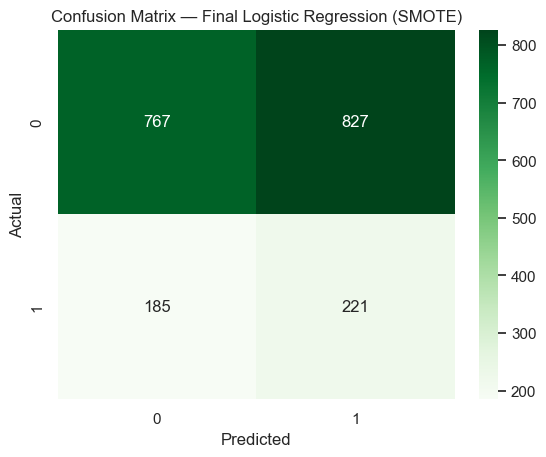

In [62]:
# Oversample minority class with SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)

# Train Logistic Regression (best hyperparameters from tuning)
final_model = LogisticRegression(
    class_weight=None,
    solver='saga',
    penalty="l1",
    C=0.1,
    max_iter=2000,
    random_state=42
)
final_model.fit(X_train_sm, y_train_sm)

# Evaluate on test set
y_pred = final_model.predict(X_test_scaled)
y_prob = final_model.predict_proba(X_test_scaled)[:, 1]

# Visualize performance
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix — Final Logistic Regression (SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 11. Model Evaluation

**Obeservations:**
- Recall (54%) for churners -> The model captures just over half of employees who actually left, a valuable trait in churn prediction, where identifying potential leavers is more important than minimizing false alarms.
- Precision (21%) for churners -> Many predicted churners were false positives (stayed), but this is acceptable in HR analytics where the cost of false negatives (missed leavers) is higher.
- High Precision (81%) but low Recall (48%) for “Stayed” -> The model confidently recognizes most non-churners but struggles to distinguish them from churners in overlapping feature zones.
- F1-scores (0.60 vs 0.30) show asymmetry: the model performs better on the majority class but still detects minority churns more effectively than baseline models.
- ROC-AUC (0.52) indicates limited discriminative power. The model’s ability to rank churn risk is slightly above random chance, expected in synthetic datasets with subtle feature relationships.
- Confusion Matrix:
    - True Negatives (767) -> Correctly identified non-churners.
    - False Positives (827) -> Employees predicted to leave but actually stayed (precision issue).
    - False Negatives (185) -> Employees who left but were predicted to stay — lower count thanks to SMOTE.
    - True Positives (221) -> Correctly identified churners — improved compared to earlier models.
- The ROC curve sits near the diagonal line, suggesting weak separation between churn and non-churn classes.
- Still, the presence of curve above 0.5 shows some predictive capacity, supporting incremental improvement from earlier baselines.

=== Final Model Evaluation (Logistic Regression + SMOTE) ===
Accuracy:  0.4940
Precision: 0.2109
Recall:    0.5443
F1-Score:  0.3040
ROC-AUC:   0.5217

Classification Report:
              precision    recall  f1-score   support

  Stayed (0)       0.81      0.48      0.60      1594
    Left (1)       0.21      0.54      0.30       406

    accuracy                           0.49      2000
   macro avg       0.51      0.51      0.45      2000
weighted avg       0.68      0.49      0.54      2000



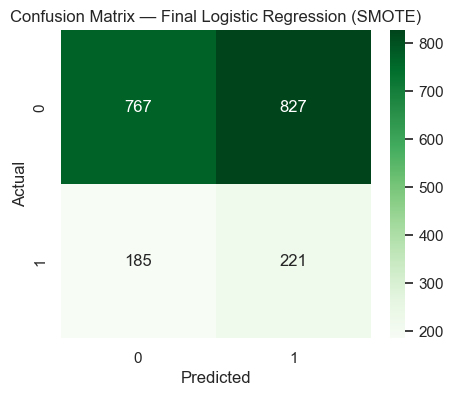

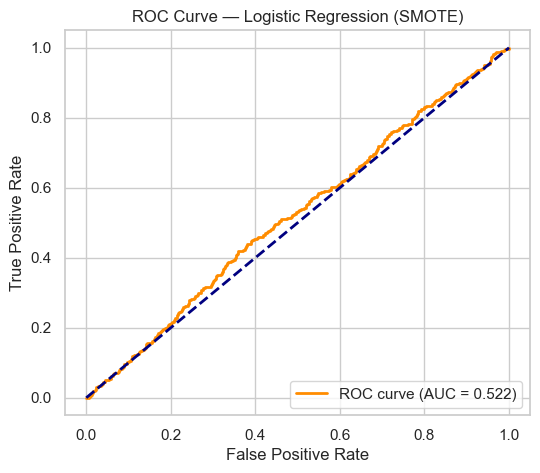

In [63]:
# --- Predictions ---
y_pred = lr_smote.predict(X_test_scaled)
y_pred_prob = lr_smote.predict_proba(X_test_scaled)[:, 1]

# --- Overall metrics ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("=== Final Model Evaluation (Logistic Regression + SMOTE) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}\n")

# --- Detailed classification report ---
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Stayed (0)", "Left (1)"]))

# --- Confusion Matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix — Final Logistic Regression (SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Logistic Regression (SMOTE)')
plt.legend(loc="lower right")
plt.show()


### 12. Model Explainability
- Feature Importance Analysis
    - The final Logistic Regression + SMOTE model provides clear insight into the behavioral and demographic factors influencing employee churn.
    - Positive coefficients indicate variables that increase churn probability, while negative coefficients correspond to those that reduce it.
    - Workload_Balance (+0.0816) - Employees reporting higher workload imbalance are more likely to leave, suggesting burnout or excessive demands.
    - Project Completed (+0.0538) - Handling too many projects may indicate overwork or stress, contributing to churn risk.
    - Training Hours (+0.0411) - Excessive training hours may correlate with role transitions or dissatisfaction with job fit.
    - Distance from Home (0.0175) - Longer commutes likely increase attrition risk due to fatigue and reduced work-life balance.
- The model confirms that workload, overcommitment, and long commutes are major churn drivers, while work-life balance, remote work, and career stability help retain employees.
- Overall, this model provides a transparent and interpretable churn-prediction framework, making it suitable for HR insights and targeted retention strategies.

,Feature,Coefficient
20,Workload_Balance,0.081577
4,Projects Completed,0.053829
5,Training Hours,0.041124
11,Distance from Home,0.017551
3,Performance Rating,0.010973
12,Manager Feedback Score,0.008285
0,Age,0.005966
35,Work Location_On-site,0.000000
28,Marital Status_Single,0.000000
24,Education Level_High School,0.000000


,Feature,Coefficient
29,Job Role_Developer,-0.046932
9,Average Monthly Hours Worked,-0.048122
30,Job Role_Manager,-0.061699
13,Work-Life Balance Encoded,-0.063353
16,Training_Intensity,-0.097352
15,Projects_Per_Year,-0.098615
33,Department_Marketing,-0.106992
36,Work Location_Remote,-0.147403
31,Job Role_Sales,-0.151539
23,Gender_Other,-0.542561


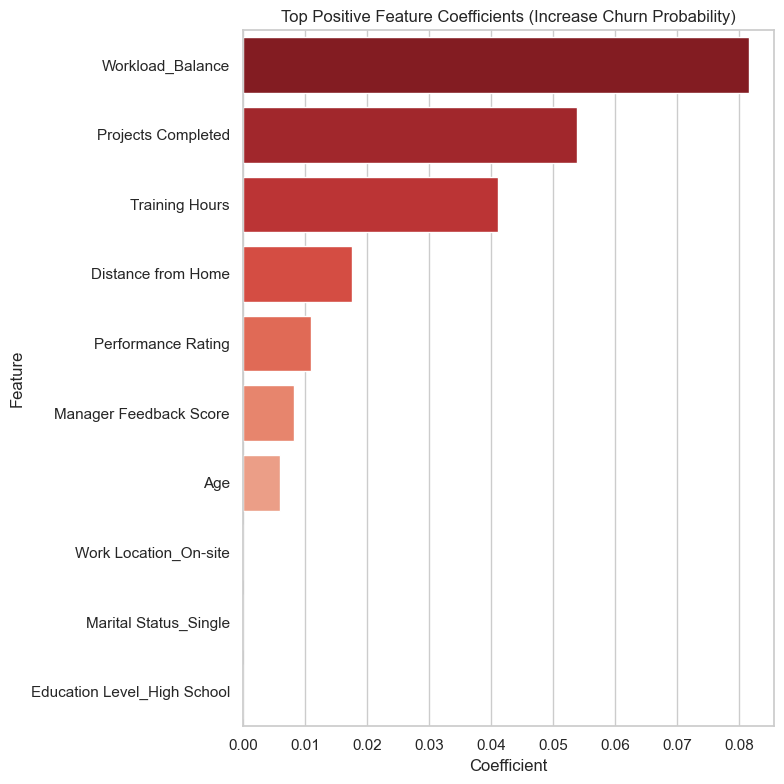

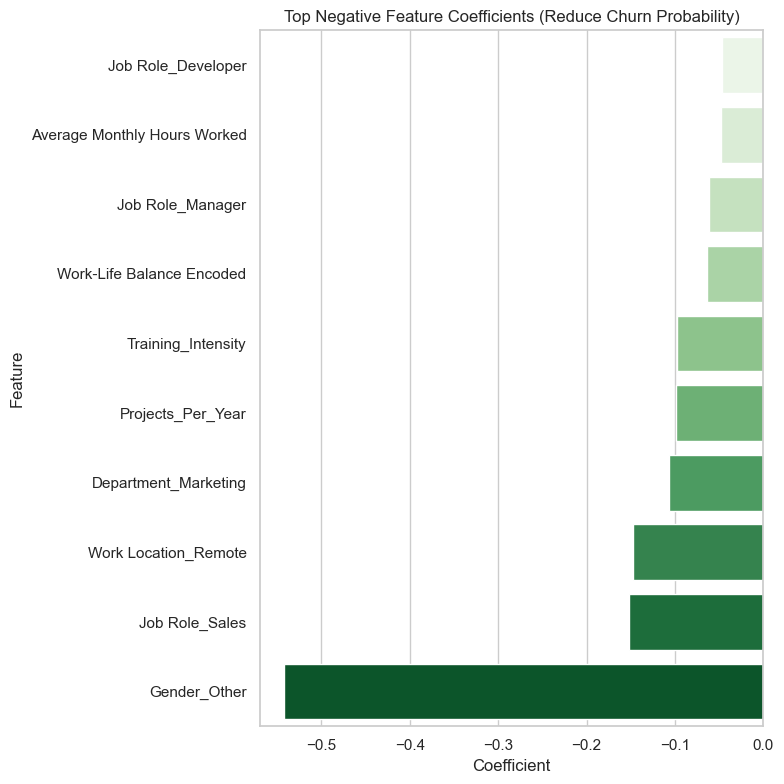

In [64]:
# Get feature names
feature_names = X_train_scaled.columns

# Get coefficients from the trained model
coefs = lr_smote.coef_.flatten()

# Create DataFrame for feature importance
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs
}).sort_values(by="Coefficient", ascending=False)

# Display top positive and negative coefficients
display(coef_df.head(10))    
display(coef_df.tail(10))   

# Plot feature importance
plt.figure(figsize=(8, 8))
sns.barplot(
    data=coef_df.head(10),
    x="Coefficient",
    y="Feature",
    palette="Reds_r"
)
plt.title("Top Positive Feature Coefficients (Increase Churn Probability)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
sns.barplot(
    data=coef_df.tail(10),
    x="Coefficient",
    y="Feature",
    palette="Greens"
)
plt.title("Top Negative Feature Coefficients (Reduce Churn Probability)")
plt.tight_layout()
plt.show()

### 13. Recommendations

1. Address Workload Imbalance and Overcommitment
<br>**Findings:** High workload imbalance and excessive projects were top churn predictors.
<br>**HR Action Plan:**
    - **Immediate (0–3 months):**
        - Launch a Workload Dashboard in collaboration with PMO or HR Analytics to track project load by team and employee.
        - Identify the top 10% of employees with chronic overload for workload redistribution.
    - **Medium-term (3–6 months):**
        - Implement mandatory cooldown periods after major project completions.
        - Pilot an “Agile Rotation Program” where employees rotate to lower-intensity teams post-delivery.
    - **Success Metrics:** 10–15% reduction in employees reporting overwork in quarterly surveys.

<br>

2. Enhance Work-Life Balance Programs
<br>**Findings:** Better work-life balance significantly reduced attrition probability.
<br>**HR Action Plan:**
    - **Immediate:**
        - Expand hybrid scheduling policies and reinforce existing wellness initiatives.
        - Introduce “No-Meeting Fridays” or flexible half-days monthly.
    - **Medium-term:**
        - Launch a Work-Life Balance Index to measure and reward managers with well-balanced teams.
    - **Success Metrics:** +20% improvement in work-life satisfaction scores; -10% reduction in burnout-related exits.

<br>

3. Leverage Remote and Hybrid Work Benefits
<br>**Findings:** Remote and hybrid workers are less likely to churn.
<br>**HR Action Plan:**
    - **Immediate:**
        - Maintain flexible remote policies post-project or post-evaluation season.
    - **Medium-term:**
        - Conduct a biannual Remote Engagement Survey to detect communication or isolation issues.
    - **Success Metrics:** Retention gap between remote and onsite staff narrowed to <5%.

<br>

4. Monitor Commute Burden and Geographic Placement
<br>**Findings:** Longer commutes correlate with higher turnover.
<br>**HR Action Plan:**
    - **Immediate:**
        - Offer commute support programs: flexible hours, shuttle subsidies, or partial remote work.
    - **Medium-term:**
        - Factor commute distance into workforce assignment planning and job relocations.
    - **Success Metrics:** 15% decrease in attrition for employees with >25 km commute.

<br>

5. Improve Manager Feedback and Career Development
<br>**Findings:** Low manager feedback and limited promotions link strongly to churn.
<br>**HR Action Plan:**
    - **Immediate:**
        -  Introduce Manager Coaching Bootcamp focused on feedback and career-pathing skills.
        - Mandate quarterly 1:1 check-ins to discuss growth plans.
    - **Medium-term:**
        - Launch an Internal Mentorship Program pairing high performers with senior leaders.
    -   **Success Metrics:** +25% increase in employees citing “manager support” in engagement surveys.

<br>

6. Use Predictive Insights for Proactive Retention
<br>**Findings:** Model Recall ≈ 0.54 — identifies ~54% of at-risk employees.
<br>**HR Action Plan:**
    - **Immediate:**
        - Integrate model output into the HR dashboard to tag high-risk employees.
        - Conduct stay interviews for top performers flagged as at-risk.
    - **Medium-term:**
        - Combine churn predictions with pulse survey data for holistic retention risk scoring.
    - **Success Metrics:** Reduce voluntary attrition by 10% within 12 months.

<br>

7. Continuous Model Improvement
<br>**Findings:** Predictive accuracy can evolve with better data and retraining.
<br>**HR Action Plan:**
    - **Immediate:**
        - Schedule biannual retraining of the model with updated workforce data.
        - Monitor precision-recall trade-offs for better balance between false alarms and missed risks.
    - **Medium-term:**
        - Explore sentiment or engagement-based features (e.g., survey tone, internal chat signals).
    - **Success Metrics:** +10% improvement in recall and ROC-AUC in future model iterations.

<br>

**Key Takeaway**
- The predictive model equips HR with a strategic, evidence-based toolkit for proactive retention management.
- By turning analytics into action like workload balancing, flexible work, and leadership development, the organization can reduce attrition, strengthen engagement, and enhance employee well-being across teams.